<a href="https://colab.research.google.com/github/omkargolatkar/actin_analysis/blob/main/Interface_matrix_generation_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interface Matrix

In [1]:
#@title Change working directory
your_directory = "\"/content/drive/MyDrive/Omkar_Masters_thesis/Actin_analysis\"" # @param {type:"string"}

%cd $your_directory

/content/drive/MyDrive/Omkar_Masters_thesis/Actin_analysis


## Install and import required modules
modules:
1. python-grpahql-client
2. rcsbsearchapi

In [ ]:
%%capture
!pip install biopython
!pip install python-graphql-client

In [ ]:
import pandas as pd
import os
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio import SeqIO
import requests, sys, json
import collections
import itertools
import time
from pprint import pprint
from python_graphql_client import GraphqlClient
from collections import Counter
from IPython.display import HTML, display
import time
from google.colab import data_table
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt

bold_start = "\033[1m"
bold_end = "\033[0m"

## load dataset

- load the complete actin dataset and apply resolution cutoff of 4 Å for filaments and 3.5 Å for non-filament structures
- actin uniprots list
- pdb sequences of all the structures


In [ ]:
#@title Actin dataset
#@markdown Load the actin structure dataset sheet (ouptut of [Actin_dataset_generation_v2.ipynb](https://colab.research.google.com/drive/1xEzbem0O57rjZX9FBVSne0z7RgsaBkFp?usp=sharing))
#@markdown Apply resolution cutoff (in Å)
df = pd.read_excel("./actin_dataset/actin_database_sheets/actin_all_entities_NA.xlsx")

df = df.iloc[:,1:]
# df3 = df3.iloc[:,1:]

df = df[df.resolution != 'none']
df.reset_index(drop=True)
df.index+=1
# df3.index+=1

filament_resolution_cutoff = 4 #@param {type: "number"}
non_filament_resloution_cutoff = 3.5 #@param {type: "number"}

# resolution cutoff of 4 A on filament and 3.5 on non-filament
df_data = df.query('(filament_status == "filament" & resolution <={fil_res}) | (filament_status == "non_filament" & resolution <={nonfil_res})'.format(fil_res = filament_resolution_cutoff, nonfil_res = non_filament_resloution_cutoff))
actin_uniprots = list(set(list(df_data['uniprot_id'])))

#@markdown Outputs -
#@markdown - **actin_pdbs** `:` pdb ids in the selected dataset **df_data**
actin_pdbs = list([entity[0:4] for entity in list(df_data['entity_id'])])

print("There are " + bold_start+ "{num_str}".format(num_str = len(list(set(actin_pdbs)))) + bold_end + " rows in the dataset after the resolution cutoff: ","\n")
print("More than one actin entities in the structures: \n",','.join(list(set([x for x in actin_pdbs if actin_pdbs.count(x) > 1]))))

actin_pdbs = list(set([entity[0:4] for entity in list(df_data['entity_id'])]))
print("actin_pdbs {num_pdbs}: ".format(num_pdbs = len(actin_pdbs)), actin_pdbs)

# get uniprot ids of actin entities
#@markdown - **actin_uniprots** `:` uniprot ids of actin entities in **df_data**
actin_uniprots = list(set(list(df_data['uniprot_id'])))

#@markdown - **pdb_sequences** `:` dictionary with - {**PDB_id : PDB sequence of actin entity**}
pdb_sequences = {}
for index, row in df_data.iterrows():
  pdb_sequences[row['entity_id'][0:4]] = row['pdb_sequence']

df_data.reset_index(inplace = True, drop = True)
df_data.index+= 1
data_table.DataTable(df_data, num_rows_per_page = 5)

There are 348 rows in the dataset after the resolution cutoff:  

More than one actin entities in the structures: 
 4JHD
actin_pdbs 348:  ['1EQY', '8D15', '7K21', '3CIP', '7PM3', '1QZ5', '3A5N', '2HMP', '8A2U', '6FM2', '3TU5', '1NM1', '7CCC', '6JH8', '1C0G', '7AHQ', '1ESV', '8C4C', '7Q8C', '2ASO', '4H0V', '4EFH', '7C2H', '2V52', '4K43', '7PLV', '8A5O', '4CBW', '7PMJ', '8X15', '7WHF', '7Z8M', '3HBT', '8F8T', '7PLZ', '8A5P', '8A2T', '6TU7', '1QZ6', '4JHD', '3U9D', '4H0Y', '5YPU', '6DJN', '6WVT', '2OAN', '7C2G', '2A42', '8GSW', '5YU8', '8P94', '6D8C', '4GY2', '8F8P', '4PKH', '7RB8', '4B1V', '7PM6', '4H03', '3A5L', '1MDU', '8DNH', '6GVC', '6T24', '7Q8B', '1Y64', '8IAH', '1IJJ', '1J6Z', '7W4Z', '7UXF', '7NVM', '8DMX', '8F8R', '4K42', '1T44', '6KLL', '7PMG', '8UEE', '7WHG', '6VAU', '4B1X', '1NLV', '6I4F', '7ALN', '7Q8S', '7ZTC', '8DNF', '7PLU', '8UXW', '2BTF', '2Q31', '1DEJ', '6MGO', '2D1K', '7RB9', '4B1Y', '7W52', '3M1F', '8GT2', '2A41', '5OOC', '7PMD', '8GSU', '5NBM', '3EKS', '7BTI', '3EL2

,entity_id,uniprot_id,pdb_chain_id,auth_chain_id,structure_title,resolution,symmetry,seq_length,method,pdb_sequence,filament_status
1,2OAN_1,P60712,"B,C,A,D","B,C,A,D",Structure of oxidized beta-actin,2.606,"Cyclic,Cyclic,Cyclic",375,X-RAY DIFFRACTION,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,non_filament
2,6F1T_2,Q6QAQ1,H,H,Cryo-EM structure of two dynein tail domains b...,3.5,"Asymmetric,Asymmetric,Helical,Cyclic,Cyclic",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,non_filament
3,7VDV_9,P60709,L,P,The overall structure of human chromatin remod...,3.4,"Asymmetric,Asymmetric,Cyclic",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,non_filament
4,7Z8M_7,Q6QAQ1,G,H,The pointed end complex of dynactin bound to B...,3.37,"Asymmetric,Asymmetric",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,non_filament
5,7ZTC_1,P60709,"B,F,H,A,C,D,E,G","B,F,H,A,C,D,E,G",Non-muscle F-actin decorated with non-muscle t...,3.9,"Helical,Helical",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,filament
...,...,...,...,...,...,...,...,...,...,...,...
345,8GT3_1,P68032,A,A,Crystal structure of human cardiac alpha actin...,1.5,Asymmetric,391,X-RAY DIFFRACTION,MGWSHPQFEKGGIEGRDDEETTALVCDNGSGLVKAGFAGDDAPRAV...,non_filament
346,8GT5_1,P68032,A,A,Crystal structure of human cardiac alpha actin...,1.4,Asymmetric,391,X-RAY DIFFRACTION,MGWSHPQFEKGGIEGRDDEETTALVCDNGSGLVKAGFAGDDAPRAV...,non_filament
347,8IAH_5,Q6QAQ1,"K,L,M,N,O,P,Q,R,S,T,U,V","A,B,C,D,E,F,G,H,I,J,K,L",Structure of mammalian spectrin-actin junction...,3.6,"Asymmetric,Helical,Cyclic,Helical",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,filament
348,8IB2_2,Q6QAQ1,"B,C,D,E,F","B,C,D,E,F",Structure of mammalian spectrin-actin junction...,3.8,"Asymmetric,Helical",375,ELECTRON MICROSCOPY,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,filament


## functions

In [ ]:
#@title functions used
#@markdown - **residue_label_seq_ids** is according to PDB numbering
#@markdown - **residue_label_ids** is according to author numbering

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def get_assembly_info(pdb_id,api_url):
  # Make a GET call to the API URL
    get_request = requests.get(url=api_url+"/"+pdb_id)
    if get_request.status_code == 200:
        # If there is data returned (with HTML status code 200)
        # then return the data in JSON format
        return get_request.json()
    else:
        # If there is no data, print status code and response
        print(get_request.status_code, get_request.text, pdb_id)
        return None

def get_interface_assembly_info(pdb_id,assembly_id,api_url):
  # Make a GET call to the API URL
    get_request = requests.get(url=api_url+"/"+pdb_id+"/"+assembly_id)
    if get_request.status_code == 200:
        # If there is data returned (with HTML status code 200)
        # then return the data in JSON format
        # print(pdb_id + "_"+assembly_id, " ok")
        return get_request.json()
    else:
        # If there is no data, print status code and response
        print(get_request.status_code, pdb_id,"_", assembly_id)
        return None

residue_numbering_type = "residue_label_seq_ids" #@param ['residue_label_seq_ids','residue_seq_ids'] {type:"string"}
def parse_interface_data_2(assembly, interface_data, chain_dict):
  interface_dict = {}
  partner_interface_dict = {}
  pdb_id = assembly.partition("_")[0]
  assembly_id = assembly.partition("_")[2]

  for interface in interface_data[pdb_id.lower()]['assembly']['interfaces']:
    # interacting chains

    if interface['molecules'][0]['molecule_class'] == 'Protein' and interface['molecules'][1]['molecule_class'] == 'Protein':
      partner1 = interface['molecules'][0]
      partner2 = interface['molecules'][1]
      p1_residues = partner1[residue_numbering_type] # residue_label_seq_ids (pdb sequence numbering) or residue_seq_ids (auth sequence numbering)
      p2_residues = partner2[residue_numbering_type]
      p1_interface_res = []
      for idx in range(0,len(p1_residues)):
        if partner1['buried_surface_areas'][idx] != 0:
          p1_interface_res.append(int(p1_residues[idx]))
      #print(p1_interface_res)
      p2_interface_res = []
      for idx in range(0,len(p2_residues)):
        if partner2['buried_surface_areas'][idx] != 0:
          p2_interface_res.append(int(p2_residues[idx]))
      p1_chain = partner1['chain_id']
      p2_chain = partner2['chain_id']

      chain_lst = chain_dict[pdb_id].split(",")
      #print(chain_lst)

      if p1_chain in chain_lst and p2_chain not in chain_lst:
        #key = (f"{pdb_id}"f"_{assembly_id}-({p1_chain}_act)-{p2_chain}")
        key = (pdb_id + "_" + assembly_id, p1_chain+"_act", p2_chain)
        interface_dict[key] = p1_interface_res
        partner_interface_dict[key] = p2_interface_res
      elif p2_chain in chain_lst and p1_chain not in chain_lst:
        #key = (f"{pdb_id}"f"_{assembly_id}-({p2_chain}_act)-{p1_chain}")
        key = (pdb_id + "_" + assembly_id, p2_chain+"_act", p1_chain)
        interface_dict[key] = p2_interface_res
        partner_interface_dict[key] = p1_interface_res
      elif p1_chain in chain_lst and p2_chain in chain_lst:
        #key = (f"{pdb_id}"f"_{assembly_id}-({p1_chain}_act)-({p2_chain}_act)")
        key = (pdb_id + "_" + assembly_id, p1_chain+"_act", p2_chain+"_act")
        interface_dict[key] = p1_interface_res
        partner_interface_dict[key] = p2_interface_res
        #key = (f"{pdb_id}"f"_{assembly_id}-({p2_chain}_act)-({p1_chain}_act)")
        key = (pdb_id + "_" + assembly_id, p2_chain+"_act", p1_chain+"_act")
        interface_dict[key] = p2_interface_res
        partner_interface_dict[key] = p1_interface_res

  return interface_dict, partner_interface_dict

def get_sifts_uni_pdb_map(pdb_id,api_url):
  # Make a GET call to the API URL
    get_request = requests.get(url=api_url+"/"+pdb_id)
    if get_request.status_code == 200:
        # If there is data returned (with HTML status code 200)
        # then return the data in JSON format
        print(pdb_id, " ok")
        return get_request.json()
    else:
        # If there is no data, print status code and response
        print(get_request.status_code, pdb_id)
        return None

## Interface information
-  download assembly information
- download assembly interface information

In [ ]:
#@title Assembly information
#@markdown For each pdb, the file contains information about entities in each assembly with their chain ids, names and copy number
api_url = "https://www.ebi.ac.uk/pdbe/api/pdb/entry/assembly" #@param {type:"string"}
#@markdown - **api_url** `:` https://www.ebi.ac.uk/pdbe/api/pdb/entry/assembly/2oan
savepath = "./actin_dataset/assemblies"
os.makedirs(os.path.dirname(savepath+"/tempfile"), exist_ok=True)

#@markdown - **actin_pdbs** `:` non-redundant list of all pdb ids in the **df_data**
actin_pdbs = list(set([entity[0:4] for entity in list(df_data['entity_id'])])) #list of all actin pdbs in selected dataset
out = display(progress(0, 100), display_id=True)
bar_val = 0
for pdb_id in actin_pdbs:
    completeName = os.path.join(savepath,str(pdb_id)+'.json')
    if os.path.exists(completeName) == False:
      assembly_info = get_assembly_info(pdb_id,api_url)
      # Serializing json
      json_object = json.dumps(assembly_info, indent=4)

      # Writing to sample.json
      with open(completeName, "w") as outfile:
          outfile.write(json_object)
    #print("done " + pdb_id)
    bar_val += 1
    out.update(progress(bar_val,len(actin_pdbs)))

In [ ]:
#@title Save assembly information to dataframe (do not run everytime, 3 min)
# do not run every time, take data from saved file

master_lst = []
for pdb_id in actin_pdbs:
    completeName = "./actin_dataset/assemblies/"+pdb_id+".json"
    with open(completeName, 'r') as openfile:
        result = json.load(openfile)
        for assembly in result[pdb_id.lower()]:
          polymeric_count = assembly['polymeric_count']
          details = assembly['details']
          assembly_id = assembly['assembly_id']
          master_lst.append([pdb_id,polymeric_count, details, assembly_id])

#@markdown - **assembly_df** `:` dataframe with information about type of assembly (author or software defined)
assembly_df = pd.DataFrame(master_lst, columns = ['pdb_id', 'poly_count','details','assembly_id'])
assembly_df.to_excel("./actin_dataset/actin_database_sheets/assembly_info.xlsx")

In [ ]:
#@title Assembly information

assembly_df = pd.read_excel("./actin_dataset/actin_database_sheets/assembly_info.xlsx")
assembly_df = assembly_df.iloc[:,1:]
assembly_df.index+=1
data_table.DataTable(assembly_df, num_rows_per_page = 5)

,pdb_id,poly_count,details,assembly_id
1,8GT3,2,author_and_software_defined_assembly,1
2,3EL2,1,author_defined_assembly,1
3,3UB5,2,author_and_software_defined_assembly,1
4,4EAH,4,author_and_software_defined_assembly,1
5,4EAH,4,author_and_software_defined_assembly,2
...,...,...,...,...
436,4WYB,2,author_and_software_defined_assembly,5
437,4WYB,2,author_and_software_defined_assembly,6
438,4WYB,2,author_and_software_defined_assembly,7
439,4WYB,2,author_and_software_defined_assembly,8


In [ ]:
#@title Interfaces in each assembly in the **assembly_df**
api_url = "https://www.ebi.ac.uk/pdbe/api/pisa/interfaces" #@param {type: "string"}
#@markdown - **api_url** `:` https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/2oan/1
savepath = "./actin_dataset/interface_assemblies"
os.makedirs(os.path.dirname(savepath+"/tempfile"), exist_ok=True)

#@markdown - **actin_assemblies** `:` actin containing assembly ids list
actin_assemblies = []
for index, row in assembly_df.iterrows():
    pdb_assem = row['pdb_id']+"_"+str(row["assembly_id"])
    actin_assemblies.append(pdb_assem)

out = display(progress(0, 100), display_id=True)
bar_val = 0
for assembly in actin_assemblies:
    pdb_id = assembly.partition("_")[0].lower()
    assembly_id = assembly.partition("_")[2]
    completeName = os.path.join(savepath,str(assembly)+'.json')
    if os.path.exists(completeName) == False or os.path.getsize(completeName) < 10:
      assembly_interface_info = get_interface_assembly_info(pdb_id,assembly_id,api_url)
      # Serializing json
      json_object = json.dumps(assembly_interface_info, indent=4)

      # Writing to sample.json
      with open(completeName, "w") as outfile:
          outfile.write(json_object)
    bar_val += 1
    out.update(progress(bar_val,len(actin_pdbs)))
    #print("done " + assembly)

404 1qz6 _ 1
404 1qz5 _ 1
404 2zwh _ 1
404 8glv _ 1
404 2gwj _ 1


## interface dictionary
- this dictionary is unmodified dictionary of interface residues

In [ ]:
#@title Interface dictionary
interface_assembly_dir = "./actin_dataset/interface_assemblies" #param {type: "string"}
assembly_dir = "./actin_dataset/assemblies" #param {type: "string"}
similarity_threshold = 0.8 #@param {type: "number"}
#@markdown some lists are not exactly duplicates but more or less similar, so delete based on how similar the interfaces are
#@markdown change the **similarity threshold** above to change the fraction of similarity

#@markdown - **all_actin_entities** `:` list of actin entity ids in **df_data**
all_actin_entities = list(df_data['entity_id'])
#@markdown - **chain_dict** `:` dictionary with - {**pdb id** : **actin chains**}
chain_dict = {} # dictionary with key: pdb_id and value: actin chain_ids
#@markdown - **uni_map** `:` dictionary with - {**pdb id** : **actin uniprot id**}
uni_map ={} # dictionary with key: pdb_id and value: uniprot id of actin entity


for index, row in df_data.iterrows():
  chain_dict[row['entity_id'][0:4]] = ''
  uni_map[row['entity_id'][0:4]] = row['uniprot_id']
for index, row in df_data.iterrows():
  chain_dict[row['entity_id'][0:4]] = (','.join([chain_dict[row['entity_id'][0:4]],row['auth_chain_id']]))
for key, value in chain_dict.items():
  chain_dict[key] = value[1:]

#@markdown - **interface_assemblies_to_look** `:` list of non-empty interface files (empty interface file may indicate lack of protein-protein interface)
# look at non-empty interface assembly files
interface_assemblies_to_look = []
for interface_assembly in os.listdir(interface_assembly_dir)[0:]:
  interface_file_path = os.path.join(interface_assembly_dir,interface_assembly)
  filesize = os.path.getsize(interface_file_path)
  if filesize >= 10:
    interface_assemblies_to_look.append(interface_assembly)

#@markdown - **all_interfaces_dict** `:` dictionary with - {**assembly_id-chain1-chain2 : list of interface residues of chain1** (pdb sequence numbering)}
all_interfaces_dict = {}

for interface_assembly in interface_assemblies_to_look[0:]:
  interface_file_path = os.path.join(interface_assembly_dir,interface_assembly)
  assembly = interface_assembly.partition(".")[0]
  pdb_id = assembly.partition("_")[0]
  #print(assembly)
  f = open(interface_file_path)
  interface_assembly_data = json.load(f)
  f.close()
  #print(interface_assembly_data[assembly.partition("_")[0].lower()]['assembly']['interface_count'])
  #print(chain_dict['4EAH'])
  if interface_assembly_data[assembly.partition("_")[0].lower()]['assembly']['interface_count'] != 0:
    interface_file, partner_interface_file = parse_interface_data_2(assembly,interface_assembly_data,chain_dict) # dictionary with key: assembly_id-(chain1)-(chain2) and value: interface residues of chain1

  #delete duplicates
  #delete duplicate interface residue lists from assembly
  all_interface_res_values = list(k for k,_ in itertools.groupby(list(interface_file.values()))) # lists of interface residues from single assembly (list of lists)

  res1 = {} # subdictionary of interface_file with key: assembly_id-(chain1)-(chain2) and value: interface residues of chain1 with exact duplicate lists deleted
  for val in all_interface_res_values:
    for assembly_k in interface_file.keys():
      if interface_file[assembly_k] == val:
        res1[assembly_k] = val
        break

  for key1, value1 in res1.items():
    for key2, value2 in res1.items():
      a = set(value1)
      b = set(value2)
      commonset_len = len(a & b)
      min_len = min(len(a),len(b))
      common_fract = commonset_len/min_len
      #interface_corr[key1+"and"+key2] = common_fract
      if len(a) <= len(b):
        resulting_list = list(value1)
        if common_fract >= similarity_threshold:
          resulting_list.extend(x for x in value2 if x not in resulting_list)
          resulting_list.sort()
          res1[key1] = resulting_list # now the interface residue lists are again duplicated so delete the duplicate lists again

  all_interface_res_values_1 = list(k for k,_ in itertools.groupby(list(res1.values()))) # lists of interface residues from single assembly (list of lists)

  for res_lst in all_interface_res_values_1:
    for assembly_k in interface_file.keys():
      if interface_file[assembly_k] == res_lst:
        all_interfaces_dict[assembly_k] = res_lst # subdictionary of interface_file with key: assembly_id-(chain1)-(chain2) and value: interface residues of chain1 with exact and partial duplicate lists deleted
        break
#@markdown - **all_partner_interfaces_dict** `:` dictionary with - {**assembly_id-chain1-chain2 : list of interface residues of chain2** (pdb sequence numbering)}
all_partner_interfaces_dict = {}
for interface_assembly in interface_assemblies_to_look[0:]:
  interface_file_path = os.path.join(interface_assembly_dir,interface_assembly)
  assembly = interface_assembly.partition(".")[0]
  pdb_id = assembly.partition("_")[0]
  #print(assembly)
  f = open(interface_file_path)
  interface_assembly_data = json.load(f)
  f.close()
  if interface_assembly_data[assembly.partition("_")[0].lower()]['assembly']['interface_count'] != 0:
    interface_file, partner_interface_file = parse_interface_data_2(assembly,interface_assembly_data,chain_dict) # dictionary with key: assembly_id-(chain1)-(chain2) and value: interface residues of chain1

  for key, value in partner_interface_file.items():
    if key in list(all_interfaces_dict.keys()):
      all_partner_interfaces_dict[key] = value


In [ ]:
#@title Remove software defined assemblies (if no. of assemblies > 1)
assembly_info_df = pd.read_excel("./actin_dataset/actin_database_sheets/assembly_info.xlsx")
assembly_info_df = assembly_info_df.iloc[:,1:]
assembly_info_df = assembly_info_df[assembly_info_df.assembly_id != 1]
assembly_info_df.reset_index()
assembly_info_df.index+= 1

remove_rows_lst = []
for index, row in assembly_info_df.iterrows():
  if row['details'] == 'software_defined_assembly':
    remove_rows_lst.append(row['pdb_id']+"_"+str(row["assembly_id"]))

rem_dict = {}

for item in remove_rows_lst:
  for key, value in all_interfaces_dict.items():
    if item  in key:
      #print(key, item)
      rem_dict[key] = value

all_interfaces_dict = {k: v for k, v in all_interfaces_dict.items() if k not in rem_dict}

rem_dict = {}

for item in remove_rows_lst:
  for key, value in all_partner_interfaces_dict.items():
    if item  in key:
      #print(key, item)
      rem_dict[key] = value

all_partner_interfaces_dict = {k: v for k, v in all_partner_interfaces_dict.items() if k not in rem_dict}

In [ ]:
#@title check interface dictionary

pdb_id = "4M63" #@param {type:"string"}
for key, value in all_interfaces_dict.items():
  if pdb_id in key[0]:
    print(bold_start+"Interface residues of actin (PDB numbering):"+bold_end, key, value)
    print(bold_start+"Interface residues of interactor (PDB numbering):"+bold_end, key, all_partner_interfaces_dict[key])

Interface residues of actin (PDB numbering): ('4M63_1', 'C_act', 'A') [39, 41, 42, 43, 44, 45, 64, 65, 66, 70, 71, 74, 77, 78, 79, 80, 81, 82, 114, 115, 116, 117, 119, 120, 123, 127, 201, 203, 204, 205, 206, 369, 373]
Interface residues of interactor (PDB numbering): ('4M63_1', 'C_act', 'A') [6, 8, 9, 12, 32, 35, 36, 37, 38, 110, 112, 114, 117, 121, 122, 123, 124, 125, 126, 128, 129, 132, 133, 136, 139, 147, 162, 165, 166, 167, 170, 175, 220]
Interface residues of actin (PDB numbering): ('4M63_1', 'E_act', 'B') [197, 198, 199, 200, 201, 202, 207, 210, 213, 217, 218, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]
Interface residues of interactor (PDB numbering): ('4M63_1', 'E_act', 'B') [76, 77, 80, 81, 82, 83, 84, 85, 86, 87, 103, 104, 107, 108, 111, 112, 113, 114, 122, 124]
Interface residues of actin (PDB numbering): ('4M63_1', 'E_act', 'D_act') [65, 66, 189, 193, 196, 197, 198, 199, 201, 203, 205, 269, 270]
Interface residues of interactor (PDB numbering): ('4M63_1

In [ ]:
#@title check interface dictionary

pdb_id = "8D14"
for key, value in all_interfaces_dict.items():
  if pdb_id in key[0]:
    print(bold_start+"Interface residues of actin (PDB numbering):"+bold_end, key, ','.join(map(str, value)))
    # print(bold_start+"Interface residues of interactor (PDB numbering):"+bold_end, key, ','.join(map(str, all_partner_interfaces_dict[key])))

Interface residues of actin (PDB numbering): ('8D14_1', 'B_act', 'C_act') 141,144,145,149,150,167,168,169,170,171,172,173,174,175,285,288,289,290,291,292,293,296,324,326,327,348,351,353,354,357,377
Interface residues of actin (PDB numbering): ('8D14_1', 'C_act', 'B_act') 40,41,42,43,44,45,46,47,48,49,51,52,55,62,63,64,65,66,202,204,206,207,210,243,244,245,246,247,248,249
Interface residues of actin (PDB numbering): ('8D14_1', 'A_act', 'B_act') 41,42,67,68,193,196,197,198,199,201,203,204,205,268,269,270
Interface residues of actin (PDB numbering): ('8D14_1', 'B_act', 'A_act') 77,112,113,114,115,116,174,175,177,179,180,181,270,271,272,273


## pdb data api

In [ ]:
#@title Actin companions in the dataset (using PDB-data-API)
ids_lst = json.dumps(actin_pdbs) #string of list of entry ids from search api

#data api to get structure title
query = '''
{
  entries(entry_ids: %s) {
    rcsb_id
    polymer_entities {
      polymer_entity_instances {
        rcsb_polymer_entity_instance_container_identifiers {
          asym_id
          auth_asym_id
        }
      }
      rcsb_polymer_entity {
        pdbx_description
      }
      rcsb_polymer_entity_container_identifiers {
        entity_id
        reference_sequence_identifiers {
          database_accession
          database_name
        }
      }
    }
  }
}
'''

data_query = query % (ids_lst)
url_data_api = 'https://data.rcsb.org/graphql' #param {type:"string"}
# instantiate client with the RCSB Data API endpoint
client = GraphqlClient(endpoint = url_data_api)
#pdb_string = ','.join(map("'{0}'".format, pdb_ids))
#query_variables = { 'entry_ids': pdb_string }
result = client.execute(query=data_query)
result = result['data']
#pprint(result['entries'][0:1])

#save output
# Serializing json
json_object = json.dumps(result, indent=4)

In [ ]:
#@title Actin and its companions in the dataset (JSON to Dataframe)

master_lst = []
for entry in result['entries']:
  pdb_id = entry['rcsb_id']

  for entity in entry['polymer_entities']:
    try:
      accessions = []
      for acc in entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers']:
        if acc['database_name'] == "UniProt":
          accessions.append(acc['database_accession'])
      uni_acc = ','.join(accessions)
      entity_uniprot_id = uni_acc
    except TypeError:
      entity_uniprot_id = 'none'
      accessions = ['none']

    accessions_mod = []
    if len(accessions) > 1:
      for uni_id in accessions:
        if len(uni_id) <= 6:
          accessions_mod.append(uni_id)
    else:
      accessions_mod = accessions.copy()
    entity_id = entity['rcsb_polymer_entity_container_identifiers']['entity_id']
    #pdb chains
    pdb_chains = []
    auth_chains = []
    for chain_dict in entity['polymer_entity_instances']:
      pdb_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['asym_id'])
      auth_chains.append(chain_dict['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
    asym_ids = ','.join(pdb_chains)
    auth_asym_ids = ','.join(auth_chains)
    entity_name = entity['rcsb_polymer_entity']['pdbx_description']

    for unp in accessions_mod:
      #if unp not in actin_uniprots:
        master_lst.append([pdb_id,entity_id,unp,asym_ids,auth_asym_ids,entity_name])
#@markdown - **df_entities** `:` all entities in all the actin structures
df_entities = pd.DataFrame(master_lst,columns=['pdb_id','entity_id','uniprot_id','pdb_chain_id','auth_chain_id','entity_name'])
df_entities = df_entities[df_entities.uniprot_id != 'none']
df_entities.reset_index(inplace = True, drop = True)
df_entities.index+=1 # all entities in all the actin structures

# df_entities.loc[df_entities['uniprot_id'] == 'L0I5A1', 'uniprot_id'] = 'Q87GE5'
data_table.DataTable(df_entities, num_rows_per_page = 5)

,pdb_id,entity_id,uniprot_id,pdb_chain_id,auth_chain_id,entity_name
1,1EQY,2,P68135,B,A,ALPHA ACTIN
2,1EQY,1,P06396,A,S,GELSOLIN
3,8D15,1,P68139,"A,B,C,D,E,F,G","A,B,C,D,E,F,G","Actin, alpha skeletal muscle"
4,7K21,1,P68139,"A,B,C,D","A,B,C,D","Actin, alpha skeletal muscle"
5,3CIP,1,P07830,A,A,Major actin
...,...,...,...,...,...,...
954,7PLW,3,P68135,C,C,"Actin, alpha skeletal muscle"
955,7PLW,1,P14649,A,B,Myosin light chain 6B
956,7PLW,2,Q02440,B,A,Unconventional myosin-Va
957,2Q0U,1,P68135,A,A,Actin


In [ ]:
#@title Update keys of interface residue dictionaries
pdb_chain_unp_lst = []
for idx, row in df_entities.iterrows():
  chain_lst = row['auth_chain_id'].split(",")
  for ch in chain_lst:
    pdb_chain_unp_lst.append((row['pdb_id']+ "-" + ch, row['uniprot_id']))

#@markdown - **all_interfaces_dict_with_uniprot** `:` dictionary with - {**(assembly_id, (chain1,ch1_uniprot), (chain2,ch2_uniprot)) : list of interface residues of chain1** (pdb sequence numbering)}
all_interfaces_dict_with_uniprot = {}
for key, value in all_interfaces_dict.items():
  pdb_id = key[0].partition("_")[0]
  chain1 = key[1].partition("_")[0]
  chain2 = key[2]
  if "_act" in chain2:
    chain2 = chain2.partition("_")[0]
  elif "-" in chain2:
    chain2 = chain2.partition("-")[0]

  elem_nm = [pdb_id + "-" + chain1, pdb_id + "-" +chain2 ]
  sub_pdb_chain_unp_lst = [elem for elem in pdb_chain_unp_lst if elem[0].startswith(tuple(elem_nm))]
  if len(sub_pdb_chain_unp_lst) == 2 and sub_pdb_chain_unp_lst[0][0] != sub_pdb_chain_unp_lst[1][0]:
    if sub_pdb_chain_unp_lst[0][0].partition("-")[2] == chain1:
      ch1_new = (key[1],sub_pdb_chain_unp_lst[0][1])
      ch2_new = (key[2],sub_pdb_chain_unp_lst[1][1])
    elif sub_pdb_chain_unp_lst[1][0].partition("-")[2] == chain1:
      ch1_new = (key[1],sub_pdb_chain_unp_lst[1][1])
      ch2_new = (key[2],sub_pdb_chain_unp_lst[0][1])

    newkey = (key[0], ch1_new, ch2_new)
    all_interfaces_dict_with_uniprot[newkey] = value

#@markdown - **all_partner_interfaces_dict_with_uniprot** `:` dictionary with - {**(assembly_id, (chain1,ch1_uniprot), (chain2,ch2_uniprot)) : list of interface residues of chain2** (pdb sequence numbering)}
all_partner_interfaces_dict_with_uniprot = {}
for key, value in all_partner_interfaces_dict.items():
  pdb_id = key[0].partition("_")[0]
  chain1 = key[1].partition("_")[0]
  chain2 = key[2]
  if "_act" in chain2:
    chain2 = chain2.partition("_")[0]
  elif "-" in chain2:
    chain2 = chain2.partition("-")[0]

  elem_nm = [pdb_id + "-" + chain1, pdb_id + "-" +chain2 ]
  sub_pdb_chain_unp_lst = [elem for elem in pdb_chain_unp_lst if elem[0].startswith(tuple(elem_nm))]
  if len(sub_pdb_chain_unp_lst) == 2 and sub_pdb_chain_unp_lst[0][0] != sub_pdb_chain_unp_lst[1][0]:
    if sub_pdb_chain_unp_lst[0][0].partition("-")[2] == chain1:
      ch1_new = (key[1],sub_pdb_chain_unp_lst[0][1])
      ch2_new = (key[2],sub_pdb_chain_unp_lst[1][1])
    elif sub_pdb_chain_unp_lst[1][0].partition("-")[2] == chain1:
      ch1_new = (key[1],sub_pdb_chain_unp_lst[1][1])
      ch2_new = (key[2],sub_pdb_chain_unp_lst[0][1])
    newkey = (key[0], ch1_new, ch2_new)
    all_partner_interfaces_dict_with_uniprot[newkey] = value

In [ ]:
#@title Check modified interface dictioanry
pdb_id = "8BR0" #@param {type:"string"}
for key, value in all_interfaces_dict_with_uniprot.items():
  if pdb_id in key[0] :
    print(bold_start+"Interface residues (PDB numbering):"+bold_end,key, value)
    print(bold_start + "Interface residues (uniprot numbering):"+bold_end, key, all_partner_interfaces_dict_with_uniprot[key])

Interface residues (PDB numbering): ('8BR0_1', ('A_act', 'P68135'), ('B', 'P07737')) [16, 23, 24, 25, 26, 27, 28, 30, 31, 32, 56, 57, 59, 60, 61, 62, 63, 64, 93, 143, 144, 145, 146, 147, 148, 167, 168, 204, 215, 243, 244, 305, 333, 334, 336, 337, 341, 344, 345, 346, 348, 349, 350, 351, 352, 355]
Interface residues (uniprot numbering): ('8BR0_1', ('A_act', 'P68135'), ('B', 'P07737')) [224, 225, 226, 227, 228, 229, 230, 231, 233, 235, 245, 246, 247, 248, 250, 251, 253, 254, 369, 372, 374, 392, 395, 396, 397, 399, 400, 403, 404, 406, 407, 408, 410, 411, 412, 413]
Interface residues (PDB numbering): ('8BR0_2', ('C_act', 'P68135'), ('D', 'P07737')) [16, 23, 24, 25, 26, 27, 28, 30, 31, 32, 56, 57, 59, 60, 61, 62, 63, 64, 88, 93, 143, 144, 145, 146, 147, 148, 167, 168, 204, 215, 243, 244, 245, 305, 333, 334, 336, 337, 341, 344, 345, 346, 348, 349, 352]
Interface residues (uniprot numbering): ('8BR0_2', ('C_act', 'P68135'), ('D', 'P07737')) [225, 226, 227, 228, 229, 230, 233, 235, 245, 246, 24

## SIFTS mapping


In [ ]:
#@title SIFTS mappings for each PDB
# map pdb sequence to uniprot sequence
# based on mapping update interface residues
# do MSA based on uniprot ids
# based on gapped seq update interface residues

#sifts_url = "https://www.ebi.ac.uk/pdbe/api/mappings/uniprot"
sifts_url = "https://www.ebi.ac.uk/pdbe/api/mappings/uniprot_segments" #@param {type:"string"}
#@markdown - **sifts_url** `:` https://www.ebi.ac.uk/pdbe/api/mappings/uniprot_segments/2oan
savepath = "./actin_dataset/sifts_ui_pdb_mappings" #param {type:"string"}
os.makedirs(os.path.dirname(savepath+'/tempfile'), exist_ok=True)
out = display(progress(0, 100), display_id=True)
bar_val = 0
for pdb_id in actin_pdbs:
  completeName = os.path.join(savepath,str(pdb_id)+'.json')
  if os.path.exists(completeName) == False:
    sifts_map = get_sifts_uni_pdb_map(pdb_id, sifts_url)
    json_object = json.dumps(sifts_map, indent=4)

    with open(completeName, "w") as outfile:
      outfile.write(json_object)
  bar_val += 1
  out.update(progress(bar_val,len(actin_pdbs)))

In [ ]:
#@title Map uniprot numbering to PDB sequence numbering
sifts_map_dir = "./actin_dataset/sifts_ui_pdb_mappings" #param {type:"string"}

#@markdown - **actin_uniprots** `:` non-redundant list of all the actin entities in **df_data**
actin_uniprots = list(set(list(uni_map.values())))

#@markdown - **uni_to_pdb_mappings** `:` uniprot to PDB mapping offset for each chain
uni_to_pdb_mappings = {}

for sifts_map in os.listdir(sifts_map_dir):
  uni_pdb_sifts_map = os.path.join(sifts_map_dir,sifts_map)
  pdb_id = sifts_map.partition(".")[0].lower()
  uniprot_id_lst = []

  f = open(uni_pdb_sifts_map)
  uni_pdb_data = json.load(f)
  f.close()
  for unp in list(uni_pdb_data[pdb_id]['UniProt']):
      uniprot_id_lst.append(unp)
  inner_dict2 = {}
  for uniprot_id in uniprot_id_lst:

    inner_dict1 = defaultdict(list)
    for instance in uni_pdb_data[pdb_id]['UniProt'][uniprot_id]['mappings']:
      pdb_start = instance['start']['residue_number']
      pdb_end = instance['end']['residue_number']
      uni_start = instance['unp_start']
      uni_end = instance['unp_end']
      chain_id = instance['chain_id']
      inner_dict1[chain_id].append([pdb_start,pdb_start - uni_start])

      if (pdb_end-pdb_start) != (uni_end-uni_start):
        print(uniprot_id,pdb_id, chain_id, pdb_end, pdb_start, uni_end, uni_start)
    inner_dict2[uniprot_id] = inner_dict1
  uni_to_pdb_mappings[pdb_id] = inner_dict2

Q9NPI1 7vdv T 652 1 651 1


In [ ]:
#@title Check mapping
pdb_id = "8BR0" #@param {type:"string"}
uni_to_pdb_mappings[pdb_id.lower()]

{'P68135': defaultdict(list, {'A': [[1, -2]], 'C': [[1, -2]]}),
 'A0A9P1NJI6': defaultdict(list, {'B': [[5, -3450]], 'D': [[5, -3450]]}),
 'P07737': defaultdict(list, {'B': [[453, 451]], 'D': [[453, 451]]})}

## Modified interface residue dictionary
- this dictionary has interface residues as per the numberings in the uniprot sequence of the respective actin entity

In [ ]:
#@title Modified interface dictionary according to uniprot numbering

#@markdown - **all_interfaces_dict_new** `:`
all_interfaces_dict_new = {} #interface residues according to uniprot numbering
for key, value in all_interfaces_dict_with_uniprot.items():
  pdb_id = key[0].partition("_")[0].lower()
  unp_id = key[1][1]
  ch_id = key[1][0].partition("_")[0]
  mapping_offset = uni_to_pdb_mappings[pdb_id][unp_id][ch_id]
  num_lst = len(mapping_offset)
  mod_value = []
  if num_lst > 1:
    for idx in range(0,num_lst-1):
      for interface_res in value:
        if mapping_offset[idx][0] <= interface_res < mapping_offset[idx+1][0]:
          interface_res_mod = interface_res - mapping_offset[idx][1]
          mod_value.append(interface_res_mod)
        elif interface_res >= mapping_offset[idx+1][0]:
          interface_res_mod = interface_res - mapping_offset[idx+1][1]
          mod_value.append(interface_res_mod)
    all_interfaces_dict_new[key] = mod_value
  else:
    for interface_res in value:
      interface_res_mod = interface_res - mapping_offset[0][1]
      mod_value.append(interface_res_mod)
    all_interfaces_dict_new[key] = mod_value

#@markdown - **all_partner_interfaces_dict_new** `:`
all_partner_interfaces_dict_new = {} #interface residues according to uniprot numbering
for key, value in all_partner_interfaces_dict_with_uniprot.items():
  pdb_id = key[0].partition("_")[0].lower()
  unp_id = key[2][1]
  ch_id = key[2][0].partition("_")[0]
  if '-' in ch_id:
    ch_id = ch_id.partition("-")[0]
  mod_value = []
  try:
    mapping_offset = uni_to_pdb_mappings[pdb_id][unp_id][ch_id]
    num_lst = len(mapping_offset)
    if num_lst > 1:
      for idx in range(0,num_lst-1):
        for interface_res in value:
          if mapping_offset[idx][0] <= interface_res < mapping_offset[idx+1][0]:
            interface_res_mod = interface_res - mapping_offset[idx][1]
            mod_value.append(interface_res_mod)
          elif interface_res >= mapping_offset[idx+1][0]:
            interface_res_mod = interface_res - mapping_offset[idx+1][1]
            mod_value.append(interface_res_mod)
      all_partner_interfaces_dict_new[key] = mod_value
    else:
      for interface_res in value:
        interface_res_mod = interface_res - mapping_offset[0][1]
        mod_value.append(interface_res_mod)
      all_partner_interfaces_dict_new[key] = mod_value
  except:
    all_partner_interfaces_dict_new[key] = mod_value

KeyError: 'P68139'

In [ ]:
#@title Check modified interface dictioanry
pdb_id = "8BR0" #@param {type:"string"}
# for key, value in all_interfaces_dict_with_uniprot.items():
#   if pdb_id in key[0] :
#     print(bold_start+"Interface residues (PDB numbering):"+bold_end,key, value)
#     print(bold_start + "Interface residues (uniprot numbering):"+bold_end, key, all_interfaces_dict_new[key])

for key, value in all_interfaces_dict_new.items():
  if pdb_id in key[0] :
    print(bold_start+"Interface residues (PDB numbering):"+bold_end,key, value)
    print(bold_start + "Interface residues (uniprot numbering):"+bold_end, key, all_partner_interfaces_dict_new[key])

In [ ]:
#@title Save partner interface dictionary with uniprot

savepath = "./actin_dataset/actin_database_sheets"

#json_object = pickle.dumps(all_partner_interfaces_dict_with_uniprot, indent=4)

with open(os.path.join(savepath,"partner_interface_dictionary_unp.pkl"), 'wb') as f:
    # pickle.dump(all_partner_interfaces_dict_with_uniprot, f)
    pickle.dump(all_partner_interfaces_dict_new, f)

# with open(os.path.join(savepath,"partner_interface_dictionary_unp.pkl"), 'rb') as g:
#     json_object = pickle.load(g)

## Multiple Sequence Alignment (MSA)


In [ ]:
#@title function
# Documentation: https://www.uniprot.org/help/api
WEBSITE_API = "https://rest.uniprot.org/"

# Documentation: https://www.ebi.ac.uk/proteins/api/doc/
PROTEINS_API = "https://www.ebi.ac.uk/proteins/api"

# Helper function to download data
def get_url(url, **kwargs):
  response = requests.get(url, **kwargs);

  if not response.ok:
    print(response.text)
    response.raise_for_status()
    sys.exit()

  return response

In [ ]:
#@title ClustalO API - submit job
joined = ",".join(actin_uniprots) #comma separated list of actin uniprot ids in string format

r_sequences = get_url(f"{WEBSITE_API}/uniprotkb/accessions?accessions={joined}&format=fasta")
fasta = r_sequences.text
#print(fasta)

your_email = "omkar.golatkar@students.iiserpune.ac.in" #@param {type:"string"}
output_order = "aligned" # @param ["aligned", "input"]
output_format = "clustal_num" #@param ["clustal_num","clustal","fa","phylip"]
# submit align job using clustalo
req_msa = requests.post("https://www.ebi.ac.uk/Tools/services/rest/clustalo/run", data={
    "email": your_email,
    "iterations": 0,
    "outfmt": output_format,
    "order": output_order,
    "sequence": fasta #fasta or input
})
# documentation here https://www.ebi.ac.uk/seqdb/confluence/display/JDSAT/Clustal+Omega+Help+and+Documentation#ClustalOmegaHelpandDocumentation-RESTAPI

job_id_msa = req_msa.text
print(job_id_msa)

clustalo-R20240408-101404-0318-22591484-p1m


In [ ]:
#@title ClustalO API - get job status
# # # get job status
r_msa_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id_msa}")
print(r_msa_status.text)

FINISHED


In [ ]:
time.sleep(30)

In [ ]:
#@title ClustalO API - save MSA
r_msa_clustal = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id_msa}/aln-clustal_num")
#print(r.text)
savepath = "./actin_dataset" #param {type:"string"}

MSA_filename = "actin_MSA.clustal_num" #@param {type:"string"}
with open(os.path.join(savepath, MSA_filename), "w") as f:
  f.write(r_msa_clustal.text)

sequence_filename = "actin_sequences.fasta" #@param {type:"string"}
with open(os.path.join(savepath, sequence_filename),"w") as g:
  g.write(fasta)

In [ ]:
#@title Consensus sequence
alignments = AlignIO.read("./actin_dataset/actin_MSA.clustal_num", "clustal")
#print(dir(alignment))

#@markdown - **align_dict** `:` dictionary with - {**uniprot_id : aligned sequence**}
align_dict = {}
for seq_rec in alignments._records:
  uniprot_id = (seq_rec.id).partition("|")[2].partition("|")[0]
  align_dict[uniprot_id] = seq_rec.seq
#print(align_dict)
summary_align = AlignInfo.SummaryInfo(alignments)

import warnings
warnings.filterwarnings('ignore')
#@markdown - **gap_con** `:` consensus sequence of MSA
gap_con = summary_align.gap_consensus(1,"X")

print(gap_con)

counter = 0 #199
for let in gap_con:
  if let != 'X':
    counter+=1
#################

XXXXXXXXXXVXDNGXGXXKXGXXGDDAPXXVFPSXXGXPXXXXXMXGXXXKXXXVGDEAQXKRGXLXLXYPIEHGXXXNWDDMEKIWXHXFXNXXRXXPEXHXXLLTEAPXNPKXNREXMTQIXFEXFXXPXXXXXIQAXLSLYXSGRTTGXVXDXGDGVXHXVPXYXGXXLPHAXXRXDXAGRDLTXXXMKXXXEXGXXFXTXAEXEIVRXXKEXLXYXAXXXXXEXXXXXXXXXXXEXXXELPDGXXXXXGXXRFRXPEXXFXPXXXGXXXXXGXXXXXXXXIXKCDXDXRXXLYXNXVXSGGXTMXXXXXXRXXXXXXXLAPXXXKXKXXAPPERKYSVWIGGSILXSLXTFQXMWXXKXEYXXXGPXIVHXKCF


In [ ]:
#@title Sequence dictionaries
records = list(SeqIO.parse("./actin_dataset/actin_sequences.fasta", "fasta"))
#@markdown - **uniprot_dict** `:` dictionary with {**actin_uniprot_id : uniprot sequence**}
uniprot_dict = {}
#@markdown - **gapped_dict** `:` dictionary with {**actin_uniprot_id : aligned sequence**}
gapped_dict = {}
for seq_rec in records:
  uniprot_id = (seq_rec.id).partition("|")[2].partition("|")[0]
  uniprot_dict[uniprot_id] = str(seq_rec.seq)

for key, value in align_dict.items():
  gapped_dict[key] = str(value)

## Modified interface residue dictionary 2
- This dictionary has interface residues as per the numberings in the **aligned** uniprot sequence of the respective actin entity

In [ ]:
#@title Modified interface dictionary 2

#@markdown - **all_interfaces_dict_new_gap** `:` dictionary with - {**assembly_id-chain1-chain2 : list of interface residues of chain1** (aligned sequence numbering)}
all_interfaces_dict_new_gap = {}
for key, value in all_interfaces_dict_new.items():
  pdb_id = key[0].partition("_")[0]
  uniprot_id = uni_map[pdb_id]
  gapped_seq = gapped_dict[uniprot_id]
  uniprot_seq = uniprot_dict[uniprot_id]
  gap_idx = []
  value_lst = value.copy()
  for i in range(0,len(gapped_seq)):
    if gapped_seq[i] == '-':
      gap_idx.append(i+1)
  mod_value_lst = [x for x in value_lst]
  for interface_res in value_lst:
    for item in gap_idx:
      if interface_res >= item:
        mod_value_lst.remove(interface_res)
        interface_res+=1
        mod_value_lst.append(interface_res)

  mod_value_lst = list(set(mod_value_lst))
  mod_value_lst.sort()
  all_interfaces_dict_new_gap[key] = mod_value_lst

In [ ]:
#@title Check all the interface residue dictionaries
pdb_id = "8BR0" #@param {type:"string"}

for key, value in all_interfaces_dict_new_gap.items():
  if pdb_id in key[0]:
    #print(bold_start+"Interface residues (PDB numbering):"+bold_end,key, value)
    print(bold_start+"Interface residues (uniprot numbering):"+bold_end,key, all_interfaces_dict_new[key])
    print(bold_start+"Interface residues (MSA numbering):"+bold_end,key, all_interfaces_dict_new_gap[key])

Interface residues (uniprot numbering): ('8BR0_1', ('A_act', 'P68135'), ('B', 'P07737')) [18, 25, 26, 27, 28, 29, 30, 32, 33, 34, 58, 59, 61, 62, 63, 64, 65, 66, 95, 145, 146, 147, 148, 149, 150, 169, 170, 206, 217, 245, 246, 307, 335, 336, 338, 339, 343, 346, 347, 348, 350, 351, 352, 353, 354, 357]
Interface residues (MSA numbering): ('8BR0_1', ('A_act', 'P68135'), ('B', 'P07737')) [18, 25, 26, 27, 28, 29, 30, 32, 33, 34, 58, 59, 61, 62, 63, 64, 65, 66, 95, 145, 146, 147, 148, 149, 150, 169, 170, 206, 217, 246, 247, 309, 337, 338, 340, 341, 345, 348, 349, 350, 352, 353, 354, 355, 356, 359]
Interface residues (uniprot numbering): ('8BR0_2', ('C_act', 'P68135'), ('D', 'P07737')) [18, 25, 26, 27, 28, 29, 30, 32, 33, 34, 58, 59, 61, 62, 63, 64, 65, 66, 90, 95, 145, 146, 147, 148, 149, 150, 169, 170, 206, 217, 245, 246, 247, 307, 335, 336, 338, 339, 343, 346, 347, 348, 350, 351, 354]
Interface residues (MSA numbering): ('8BR0_2', ('C_act', 'P68135'), ('D', 'P07737')) [18, 25, 26, 27, 28, 2

In [ ]:
#@title Show rows with same interface residues for a PDB

for pdb_id in actin_pdbs:
  subdict = {}
  for key, value in all_interfaces_dict_new_gap.items():
    if key[0].startswith(pdb_id):
      subdict[key] = value
  if len(list(subdict.keys())) > 1:
    for k, v in subdict.items():
      list_string = map(str, v)
      vstring = ",".join(list_string)
      subdict[k] = vstring
    #pprint(subdict)
    # finding duplicate values
    # from dictionary using flip
    flipped = {}

    for key, value in subdict.items():
      if value not in flipped:
        flipped[value] = [key]
      else:
        flipped[value].append(key)
    for k1, v1 in flipped.items():
      if len(v1)>1:
        chains = []
        for elem in v1:
          chains.append((elem[1],elem[2]))
        if len(set(chains)) < len(v1):
          print(k1,v1)

69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86 [('6WK2_1', ('Y_act', 'P63261'), ('A', 'Q86TU7')), ('6WK2_2', ('Y_act', 'P63261'), ('A', 'Q86TU7')), ('6WK2_3', ('C_act', 'P63261'), ('D', 'Q86TU7'))]
69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86 [('6WK1_1', ('Y_act', 'P63261'), ('A', 'Q86TU7')), ('6WK1_2', ('Y_act', 'P63261'), ('A', 'Q86TU7')), ('6WK1_3', ('Z_act', 'P63261'), ('B', 'Q86TU7'))]


In [ ]:
#@title Save interface dictionary

savepath = "./actin_dataset/actin_database_sheets"

with open(os.path.join(savepath,"interface_dictionary_msa.pkl"), 'wb') as f:
    pickle.dump(all_interfaces_dict_new_gap, f)

## Interface Matrix

In [ ]:
#@title Consensus sequence dictionary
#@markdown - **consensus_dict** `:` dictionary of consensus sequence with - {**residue position : residue**}
consensus_dict = {}
for i in range(0,len(gap_con)):
  consensus_dict[i+1] = gap_con[i]

In [ ]:
#@title Interface matrix generation
#@markdown **heatmap_dict** `:` dictionary of every value in interface matrix with - {**assembly_id-(chain1)-(chain2) : 0 or 1**}
heatmap_dict = {}
for chain_id, res_lst in all_interfaces_dict_new_gap.items():
  for res_idx, residue in consensus_dict.items():
    heatmap_dict[(chain_id,res_idx)] = 0.0
  for res in res_lst:
    heatmap_dict[(chain_id,res)] = 1.0

print("\033[1m" + "Number of rows in interface matrix: " + "\033[0;0m")
print(len(heatmap_dict.keys())/379)

for key, value in heatmap_dict.items():
  if key[1] > 379:
    print(key)

Number of rows in interface matrix: 
945.0


In [ ]:
#@title dictionary (**heatmap_dict**) to dataframe
ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)
print("\033[1m" + "Dimensions of interface matrix: " + "\033[0;0m")
print(interface_df.shape)

interface_matrix_dict = defaultdict(list)
for key, value in heatmap_dict.items():
  newkey = key[0]
  interface_matrix_dict[newkey].append(value)

Dimensions of interface matrix: 
(945, 379)


In [ ]:
#@title Save interface matrix
savepath = "./actin_dataset/actin_database_sheets" #@param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix.csv"))
#result_tr = df.transpose()
# interface_df.to_csv(os.path.join(savepath, "actin_interface_matrix.tsv"), sep="\t")

with open(os.path.join(savepath,"actin_interface_matrix.pkl"), 'wb') as f:
    pickle.dump(interface_matrix_dict, f)

# Domain annotations

In [ ]:
#@title Actin interactors in each PDB
interface_mtrx = "./actin_dataset/actin_database_sheets/actin_interface_matrix.csv"
#markdown - **mtrx** `-` row names of interface matrix
mtrx = pd.read_csv(interface_mtrx, index_col = 0)
data_table.DataTable(mtrx, num_rows_per_page = 5)

,1,2,3,4,5,6,7,8,9,10,...,370,371,372,373,374,375,376,377,378,379
"('1ATN_1', ('A_act', 'P68135'), ('D', 'P00639'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"('1C0F_1', ('A_act', 'P07830'), ('S', 'P06396'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
"('1C0G_1', ('A_act', 'P07830'), ('S', 'P06396'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
"('1D4X_1', ('A_act', 'P0DM41'), ('G', 'P06396'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"('1DEJ_1', ('A_act', 'P07830'), ('S', 'P06396'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"('8X19_1', ('U_act', 'P60709'), ('V', 'Q9NPF5'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"('8X1C_1', ('S_act', 'P60709'), ('I', 'Q6ZRS2'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
"('8X1C_1', ('U_act', 'P60709'), ('I', 'Q6ZRS2'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
"('8X1C_1', ('U_act', 'P60709'), ('T', 'O96019'))",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#@title Actin interactors uniprots

mtrx_rows = list(mtrx.index.values)
mtrx_rows_tuples = []
for elem in mtrx_rows:
  row_elements = elem.split(",")
  assembly_id = row_elements[0].split("'")[1]
  chain_1 = (row_elements[1].partition("'")[2].partition("'")[0], row_elements[2].partition("'")[2].partition("'")[0])
  chain_2 = (row_elements[3].partition("'")[2].partition("'")[0], row_elements[4].partition("'")[2].partition("'")[0])
  mtrx_rows_tuples.append((assembly_id, chain_1, chain_2))

interactors_uniprot_lst = []
for elem in mtrx_rows_tuples:
  actin_interactor_unp = elem[2][1]
  interactors_uniprot_lst.append(actin_interactor_unp)

interactors_uniprot_lst = list(set(interactors_uniprot_lst)) #149 uniprots including actin
only_interactors_uniprot_lst = [elem for elem in interactors_uniprot_lst if elem not in actin_uniprots] #133 from interface matrix
actin_in_interactors_uniprot_lst = [elem for elem in interactors_uniprot_lst if elem in actin_uniprots] #16

In [ ]:
#@title actin structures according to number of interacting partners after curation

act_struct_partner_uniprot_dict = {}
for pdb_id in actin_pdbs:
  act_struct_partner_uniprot_dict[pdb_id] = []
for elem in mtrx_rows_tuples:
  if 'act' not in elem[2][0]:
    actin_interactor_unp = elem[2][1]
    if actin_interactor_unp not in ['Q08641', 'P0CU65', 'P0CU64', 'P0CU63']: # these are lifeact, phalloidin
      PDB_id = elem[0][0:4]
      if actin_interactor_unp not in act_struct_partner_uniprot_dict[PDB_id]:
        act_struct_partner_uniprot_dict[PDB_id].append(actin_interactor_unp)

num_interactors = []
for k, v in act_struct_partner_uniprot_dict.items():
  if len(v) not in num_interactors:
    num_interactors.append(len(v))

num_interactors.sort()

In [ ]:
#@title actin interactors names df
act_struct_partner_names_dict = defaultdict(list)
act_companions_dict = {}

for index, row in df_entities.iterrows():
  act_companions_dict[row['uniprot_id']] = row['entity_name']

for k, v in act_struct_partner_uniprot_dict.items():
  for unip_id in v:
    act_struct_partner_names_dict[k].append(act_companions_dict[unip_id])

master_lst_entries = []
for index, row in df_data.iterrows():
  pdb_id = row['entity_id'][0:4]
  actin_uniprot = row['uniprot_id']
  structure_title = row['structure_title']
  resolution = row['resolution']
  method = row['method']
  filament_status = row['filament_status']
  interactors = ';'.join(act_struct_partner_names_dict[pdb_id])
  master_lst_entries.append([pdb_id,method,resolution,actin_uniprot,filament_status,interactors])

df_entries = pd.DataFrame(master_lst_entries,columns=['PDB ID','Method','Resolution','Actin UniProt ID','Filament status','Actin Interactors'])
df_entries = df_entries.drop_duplicates(subset = ['PDB ID'])
df_entries.index+=1

filename = "./actin_dataset/actin_database_sheets/actin_all_pdbs_res.xlsx"# add a date to the name
os.makedirs(os.path.dirname(filename), exist_ok=True)

#df3.to_excel(os.path.join(savepath,"actin_filament_entities_NA.xlsx"))
df_entries.to_excel(filename)

In [ ]:
bare_count = 0
for index, row in df_entries.iterrows():
  if row['Actin Interactors'] == '' and row['Filament status'] == 'filament':
    bare_count+=1

bare_count

70

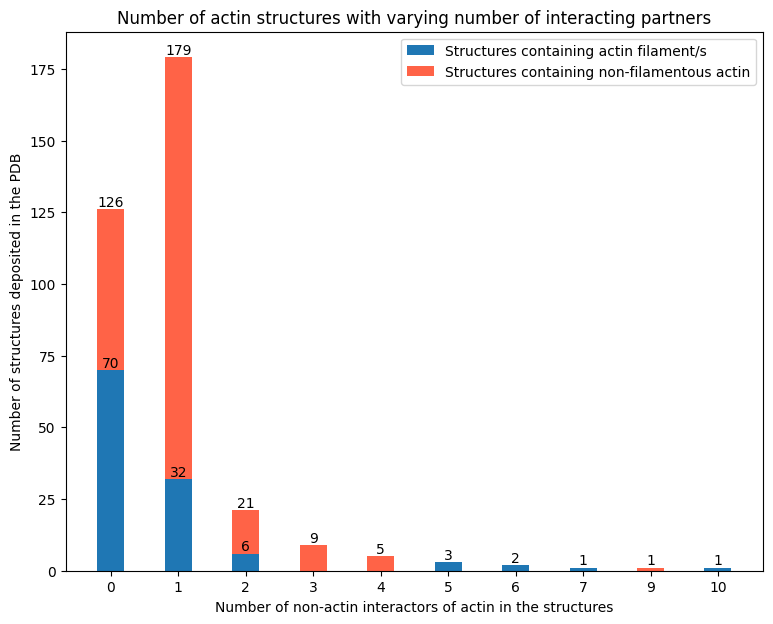

In [ ]:
#@title plots
# num_interactors
actin_filament_pdbs = []
for index, row in df_entries.iterrows():
  if row['Filament status'] == 'filament':
    actin_filament_pdbs.append(row['PDB ID'])

rise_twist_pdbs = []
df_rise_twist = pd.read_excel("./actin_dataset/actin_database_sheets/df_rise_twist.xlsx", index_col = 0)
for index, row in df_rise_twist.iterrows():
  if row['prot'] not in ['Bare-Actin','more than one interactors']:
    rise_twist_pdbs.append(index[0:4])

plot_dict = {}
plot_dict2 = {}
for i in range(0,len(num_interactors)):
  counter = 0
  counter_fil = 0
  for k, v in act_struct_partner_uniprot_dict.items():
    if len(v) == num_interactors[i]:
      counter+=1
    if k in actin_filament_pdbs and len(v) == num_interactors[i]:
      counter_fil += 1

  plot_dict[str(num_interactors[i])] = counter - counter_fil
  plot_dict2[str(num_interactors[i])] = counter_fil


x = list(plot_dict.keys())
y1 = list(plot_dict.values())
y2 = list(plot_dict2.values())

fig, ax = plt.subplots()

# bars = ax.bar(x,y1, width = 0.4, label = 'Actin structures')

bars2 = ax.bar(x,y2, width = 0.4, label = 'Structures containing actin filament/s')
#ax.bar_label(bars2)
for c in ax.containers:
    # Filter the labels
    labels = [v if v > 5 else "" for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type="edge")

bars = ax.bar(x,y1,bottom = y2,color = 'tomato',width= 0.4, label = 'Structures containing non-filamentous actin')
ax.bar_label(bars)

ax.legend()
plt.xlabel('Number of non-actin interactors of actin in the structures')
plt.ylabel('Number of structures deposited in the PDB')
plt.title('Number of actin structures with varying number of interacting partners')

fig.set_size_inches(9, 7)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)

plt.savefig('./structures_vs_num_interactors_1.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
#@title functions
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def get_annot(uniprot_id,api_url):
  # Make a GET call to the API URL
    get_request = requests.get(url=api_url+"/"+uniprot_id)
    if get_request.status_code == 200:
        # If there is data returned (with HTML status code 200)
        # then return the data in JSON format
        return get_request.json()
    else:
        # If there is no data, print status code and response
        print(get_request.status_code, get_request.text, uniprot_id)
        return None

## Representative domains

In [ ]:
#@title download annotation for actin interactors
#P12883 next doesn't work
api_url = "https://www.ebi.ac.uk/interpro/api/entry/all/protein/uniprot"
savepath = "./actin_dataset/interactor_representative_annotations_by_uniprot"
os.makedirs(os.path.dirname(savepath+"/tempfile"), exist_ok=True)
# https://www.ebi.ac.uk/interpro/api/structure/PDB/8bjh/protein/UniProt/
#actin_pdbs = list(set([entity[0:4] for entity in list(df_data['entity_id'])])) #list of all actin pdbs in selected dataset

out = display(progress(0, 100), display_id=True)
bar_val = 0
for uniprot_id in interactors_uniprot_lst:
    completeName = os.path.join(savepath,str(uniprot_id)+'.json')
    if os.path.exists(completeName) == False:
      annot_info = get_annot(uniprot_id,api_url)
      if annot_info != None:
        next = annot_info['next']
        while next != None:
          get_request = requests.get(url=next)
          annot_info1 = get_request.json()
          try:
            for domain in annot_info1['results']:
              annot_info['results'].append(domain)
            next = annot_info1['next']
          except:
            print(uniprot_id)
            next = None
      # Serializing json
      json_object = json.dumps(annot_info, indent=4)

      # Writing to sample.json
      with open(completeName, "w") as outfile:
          outfile.write(json_object)
    #print("done " + uniprot_id)
    time.sleep(0.3)
    bar_val += 1
    out.update(progress(bar_val,len(interactors_uniprot_lst)))

204  Q08561
204  L0I5A1


In [ ]:
#@title annotation dictionary
master_lst = []
domain_dict = {}
for uniprot_id in interactors_uniprot_lst:
  domain_dict[uniprot_id] = []
for uniprot_id in interactors_uniprot_lst:
    completeName = "./actin_dataset/interactor_representative_annotations_by_uniprot/"+uniprot_id+".json"
    with open(completeName, 'r') as openfile:
        result = json.load(openfile)
        #print(uniprot_id)
        if result != None:
          for domain in result['results']:
            for annot in domain['proteins']:
              prot_fragments = annot['entry_protein_locations']
              if prot_fragments != None:
                for fragment in prot_fragments:
                  for segment in fragment['fragments']:
                    rep_status = segment['representative']
                    frag_start = segment['start']
                    frag_end = segment['end']
                    entity_uniprot_id = annot['accession']
                    domain_name = domain['metadata']['name']
                    source = domain['metadata']['source_database']
                    domain_annot = domain['metadata']['accession']
                    annot_type = domain['metadata']['type']
                    domain_dict[uniprot_id].append({'accession': domain_annot, 'source': source, 'name': domain_name, 'type': annot_type, 'start':frag_start, 'end':frag_end, 'rep_status':rep_status})

In [ ]:
#@title Map representative domains to each actin interactor mod
master_lst = []

for key, value in domain_dict.items():
  for annot in value:
    master_lst.append([key, annot['accession'], annot['source'], annot['name'], annot['type'], annot['start'], annot['end'], annot['rep_status']])

df_domains = pd.DataFrame(master_lst, columns = ['uniprot_id', 'annot_id', 'annot_source', 'annot_name', 'annot_type', 'start', 'end', 'rep_status'])

df_domains_uniprots = list(df_domains['uniprot_id'])
df_domains_uniprots = list(set(df_domains_uniprots))

domain_annot_dict = {}
for unp in df_domains_uniprots:
  domain_annot_dict[unp] = []
#domain_annot_dict = defaultdict(list)

df_domains_dfhs = df_domains.query('(annot_type == "domain" & rep_status == True)|(annot_type == "domain" & annot_source == "interpro")|(annot_type == "family" & annot_source == "interpro")|(annot_type == "homologous_superfamily" & annot_source == "interpro")')
for index, row in df_domains_dfhs.iterrows():
  inner_dict = {'start':row['start'], 'end':row['end'], 'annot_id':row['annot_id'], 'annot_name':row['annot_name'], 'rep_status':row['rep_status'], 'annot_type':row['annot_type']}
  domain_annot_dict[row['uniprot_id']].append(inner_dict)

domain_annot_dict['P12883'] = [
    {
        'start':32,
        'end':81,
        'annot_id':'PS51844',
        'annot_name':'SH3_LIKE',
        'rep_status':True,
        'annot_type':'domain'
    },
    {
        'start':79,
        'end':779,
        'annot_id':'SM00242',
        'annot_name':'MYSc',
        'rep_status':True,
        'annot_type':'domain'
    },
    {
        'start':845,
        'end':1923,
        'annot_id':'IPR002928',
        'annot_name':'Myosin tail',
        'rep_status':False,
        'annot_type':'domain'
    }
                               ]

In [ ]:
remain_annot_unps = []
for k, v in domain_annot_dict.items():
  if v == []:
    remain_annot_unps.append(k)

In [ ]:
#@title check domain annotations
uniprot_id = 'Q8VQB5' #@param {type: "string"}
domain_annot_dict[uniprot_id]

[{'start': 50,
  'end': 263,
  'annot_id': 'IPR015138',
  'annot_name': 'Salmonella invasion protein A, N-terminal',
  'rep_status': False,
  'annot_type': 'domain'},
 {'start': 514,
  'end': 670,
  'annot_id': 'IPR023224',
  'annot_name': 'Salmonella invasion protein A, C-terminal actin-binding domain superfamily',
  'rep_status': False,
  'annot_type': 'homologous_superfamily'},
 {'start': 23,
  'end': 263,
  'annot_id': 'IPR023225',
  'annot_name': 'Salmonella invasion protein A, chaperone-binding',
  'rep_status': False,
  'annot_type': 'homologous_superfamily'},
 {'start': 50,
  'end': 263,
  'annot_id': 'PF09052',
  'annot_name': 'SipA N-terminal domain',
  'rep_status': True,
  'annot_type': 'domain'}]

In [ ]:
#@title load actin interactor interface dictionary
savepath = "./actin_dataset/actin_database_sheets"
with open(os.path.join(savepath,"partner_interface_dictionary_unp.pkl"), 'rb') as g:
    actin_interactor_interface_dict = pickle.load(g)

savepath = "./actin_dataset/actin_database_sheets"
with open(os.path.join(savepath,"interface_dictionary_msa.pkl"), 'rb') as g:
    actin_interactor_interface_dict_actin_res = pickle.load(g)

In [ ]:
#@title Check modified interface dictioanry
pdb_id = "8C4E" #@param {type:"string"}

for key, value in actin_interactor_interface_dict.items():
  if pdb_id in key[0] :
    print(bold_start+"Interface residues (PDB numbering):"+bold_end,key, value)
    print(bold_start + "Interface residues (uniprot numbering):"+bold_end, key, actin_interactor_interface_dict_actin_res[key])

Interface residues (PDB numbering): ('8C4E_1', ('B_act', 'P68139'), ('D_act', 'P68139')) [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 55, 62, 63, 64, 65, 66, 202, 204, 206, 207, 210, 243, 244, 245, 246, 247, 248, 249]
Interface residues (uniprot numbering): ('8C4E_1', ('B_act', 'P68139'), ('D_act', 'P68139')) [141, 144, 145, 149, 150, 167, 168, 169, 170, 171, 172, 173, 174, 175, 287, 290, 291, 292, 293, 294, 295, 298, 326, 328, 329, 350, 353, 355, 356, 359, 379]
Interface residues (PDB numbering): ('8C4E_1', ('H_act', 'P68139'), ('F_act', 'P68139')) [141, 144, 145, 149, 150, 167, 168, 169, 170, 171, 172, 173, 174, 175, 285, 288, 289, 290, 291, 292, 293, 296, 324, 326, 327, 348, 351, 353, 354, 357, 377]
Interface residues (uniprot numbering): ('8C4E_1', ('H_act', 'P68139'), ('F_act', 'P68139')) [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 62, 63, 64, 65, 66, 202, 204, 206, 207, 210, 244, 245, 246, 247, 248, 249, 250]
Interface residues (PDB numbering): ('8C4E_1', ('F_act

In [ ]:
#@title unavailable domain annotations
mod_actin_interactor_interface_dict = {}
mod_actin_interactor_interface_dict_actin_res = {}
for key1, value1 in actin_interactor_interface_dict.items():
  interactor_unp = key1[2][1]
  if interactor_unp in list(domain_annot_dict.keys()):
    mod_actin_interactor_interface_dict[key1] = value1
    mod_actin_interactor_interface_dict_actin_res[key1] = actin_interactor_interface_dict_actin_res[key1]
  else:
    print(key1, value1)

('8A5A_1', ('V_act', 'P60010'), ('X', 'Q08561')) [35, 36, 37, 38, 39, 40, 41, 42, 43, 63, 65, 66]
('8A5O_1', ('V_act', 'P60010'), ('X', 'Q08561')) [35, 36, 37, 38, 39, 40, 41, 42, 43, 63, 65, 66]
('4M63_1', ('C_act', 'P10987'), ('A', 'L0I5A1')) []
('4M63_1', ('E_act', 'P10987'), ('B', 'L0I5A1')) []
('4M63_1', ('C_act', 'P10987'), ('B', 'L0I5A1')) []


In [ ]:
#@title actin interactor domains (mod)
import numpy as np
import copy

actin_interactor_domains = defaultdict(list)

domain_annot_dict1 = copy.deepcopy(domain_annot_dict)
for key1, value1 in mod_actin_interactor_interface_dict.items():
  interactor_unp = key1[2][1]
  dom_len = 0
  domain_annotations = domain_annot_dict1[interactor_unp]
  for annot_idx, each_annot in enumerate(domain_annotations,start = 0):
    dom_start = each_annot['start']
    dom_end = each_annot['end']
    dom_status = each_annot['rep_status']
    int_res_count = 0
    for idx, int_res in enumerate(actin_interactor_interface_dict[key1], start = 1):
      if dom_start <= int_res <= dom_end:# and (dom_end - dom_start) >= dom_len:
        int_res_count+=1
    each_annot['int_res_count'] = int_res_count/ (dom_end - dom_start)
    if each_annot['int_res_count'] != 0: #and each_annot['annot_type'] == 'domain':
      actin_interactor_domains[key1].append(each_annot)


In [ ]:
actin_interactor_domains_cp = copy.deepcopy(actin_interactor_domains)

for key1, value1 in actin_interactor_domains_cp.items():
  int_domain_lst = [annotation for annotation in value1 if annotation['annot_type'] == "domain"]
  int_domain_rep_lst = [annotation['rep_status'] for annotation in value1]
  if len(int_domain_lst) == 1:
    actin_interactor_domains[key1] = [int_domain_lst[0]['annot_name']]
  elif len(int_domain_lst) > 1 and int_domain_rep_lst.count(True) == 1:
    for annotation in int_domain_lst:
      if annotation['rep_status'] == True:
        actin_interactor_domains[key1] = [annotation['annot_name']]
  elif len(int_domain_lst) > 1 and int_domain_rep_lst.count(True) > 1:
    int_res_count_lst_rep = [annotation['int_res_count'] for annotation in int_domain_lst if annotation['rep_status'] == True]
    for annotation in int_domain_lst:
      if annotation['rep_status'] == True and annotation['int_res_count'] == np.max(int_res_count_lst_rep):
        actin_interactor_domains[key1] = [annotation['annot_name']]
  elif len(int_domain_lst) >1 and int_domain_rep_lst.count(True) == 0:
    int_res_count_lst = [annotation['int_res_count'] for annotation in int_domain_lst]
    for annotation in int_domain_lst:
      if annotation['int_res_count'] == np.max(int_res_count_lst):
        actin_interactor_domains[key1] = [annotation['annot_name']]
  else:
    actin_interactor_domains[key1] = ['no_domain_annotation'] #864

for k,v in actin_interactor_domains.items():
  if len(v) > 1:
    print('domains>1', k)
    actin_interactor_domains[k] = [v[0]]

for key1, value1 in actin_interactor_domains_cp.items():
  int_family_lst = [annotation for annotation in value1 if annotation['annot_type'] == "family"]
  if len(int_family_lst) == 1:
    actin_interactor_domains[key1].append(int_family_lst[0]['annot_name'])
  elif len(int_family_lst) > 1:
    int_res_count_lst = [annotation['int_res_count'] for annotation in int_family_lst]
    for annotation in int_family_lst:
      if annotation['int_res_count'] == np.max(int_res_count_lst):
        actin_interactor_domains[key1].append(annotation['annot_name'])
  else:
    actin_interactor_domains[key1] .append('no_family_annotation')

for k,v in actin_interactor_domains.items():
  if len(v) > 2:
    print('families>1', k)
    actin_interactor_domains[k] = [v[0], v[1]]

for key1, value1 in actin_interactor_domains_cp.items():
  int_supfamily_lst = [annotation for annotation in value1 if annotation['annot_type'] == "homologous_superfamily"]
  if len(int_supfamily_lst) == 1:
    actin_interactor_domains[key1].append(int_supfamily_lst[0]['annot_name'])
  elif len(int_supfamily_lst) > 1:
    int_res_count_lst = [annotation['int_res_count'] for annotation in int_supfamily_lst]
    for annotation in int_supfamily_lst:
      if annotation['int_res_count'] == np.max(int_res_count_lst):
        actin_interactor_domains[key1].append(annotation['annot_name'])
  else:
    actin_interactor_domains[key1].append('no_supfamily_annotation')

for k,v in actin_interactor_domains.items():
  if len(v) > 3:
    print('supfamilies>1', k)
    actin_interactor_domains[k] = [v[0], v[1], v[2]]


families>1 ('3CHW_1', ('A_act', 'P07830'), ('P', 'P07737'))
families>1 ('2PBD_1', ('A_act', 'P68135'), ('P', 'P07737'))
families>1 ('8BJJ_1', ('A_act', 'P68135'), ('C', 'P07737'))
families>1 ('8BJH_1', ('A_act', 'P68135'), ('B', 'P07737'))
families>1 ('8BJI_1', ('A_act', 'P68135'), ('B', 'P07737'))
families>1 ('6NAS_1', ('A_act', 'P68135'), ('P', 'P07737'))
families>1 ('2PAV_1', ('A_act', 'P68135'), ('P', 'P07737'))
families>1 ('6NBW_1', ('A_act', 'P60709'), ('P', 'P07737'))
families>1 ('6NBE_1', ('A_act', 'P68135'), ('P', 'P07737'))
families>1 ('8C47_1', ('A_act', 'Q9U1E8'), ('B', 'Q4Q5N1'))
supfamilies>1 ('6FM2_1', ('A_act', 'P68135'), ('B-2', 'P40124'))
supfamilies>1 ('6FM2_1', ('A_act', 'P68135'), ('B', 'P40124'))
supfamilies>1 ('1H1V_1', ('A_act', 'P68135'), ('G', 'P06396'))


In [ ]:
#@title check which key is missing
for key1, value1 in mod_actin_interactor_interface_dict.items():
  if key1 not in list(actin_interactor_domains.keys()):
    print(key1)
    pass
  # elif type(actin_interactor_domains[key1]) == list:
  #   print(key1)

('8BR0_1', ('A_act', 'P68135'), ('B', 'P07737'))
('8BR0_2', ('C_act', 'P68135'), ('D', 'P07737'))
('3MMV_1', ('A_act', 'P10987'), ('X', 'Q9U1K1'))
('3MN9_1', ('A_act', 'P10987'), ('X', 'Q9U1K1'))
('8C4E_1', ('C_act', 'P68139'), ('K', 'Q8VQB5'))
('3MN6_1', ('A_act', 'P10987'), ('X', 'Q9U1K1'))
('3MN6_2', ('F_act', 'P10987'), ('Y', 'Q9U1K1'))
('3MN6_3', ('K_act', 'P10987'), ('Z', 'Q9U1K1'))
('7ZVW_1', ('B_act', 'Q9P4D1'), ('H', 'C4R7G0'))
('7AD9_1', ('B_act', 'P68135'), ('A', 'Q08641'))
('8UEE_1', ('F_act', 'P68135'), ('C', 'P0CL52'))


In [ ]:
for k, v in actin_interactor_domains.items():
  if len(v) != 3:
    print(k)

In [ ]:
ini_len = 0
non_rep = []
two_doms = {}

for key, value in actin_interactor_domains.items():
  if len(value) > ini_len:
    ini_len = len(value)
  if 'non_rep_domain' in value and len(value) == 1:
    non_rep.append(key)
  if len(value) == 2:
    two_doms[key] = value

print(ini_len)
print(len(non_rep))

3
0


In [ ]:
#@title save actin interactor domains
savepath = "./actin_dataset/actin_database_sheets"
with open(os.path.join(savepath,"actin_interactor_domains.pkl"), 'wb') as g:
    pickle.dump(actin_interactor_domains,g)

# Post processing interface matrix

In [ ]:
#@title load data
savepath = "./actin_dataset/actin_database_sheets"
with open(os.path.join(savepath,"actin_interface_matrix.pkl"), 'rb') as g:
    actin_interactor_interface_dict = pickle.load(g)

with open(os.path.join(savepath,"actin_interactor_domains.pkl"), 'rb') as g:
    actin_interactor_domains = pickle.load(g)

In [ ]:
#@title unavailable annotations
mod_actin_interactor_interface_dict = {}
for key1, value1 in actin_interactor_interface_dict.items():
  if key1 not in list(actin_interactor_domains.keys()):
    print(key1)
  else:
    mod_actin_interactor_interface_dict[key1] = value1

('8A5A_1', ('V_act', 'P60010'), ('X', 'Q08561'))
('8BR0_1', ('A_act', 'P68135'), ('B', 'P07737'))
('8BR0_2', ('C_act', 'P68135'), ('D', 'P07737'))
('8IAH_1', ('J_act', 'Q6QAQ1'), ('3', 'I3L5B0'))
('8IAH_1', ('L_act', 'Q6QAQ1'), ('0', 'A0A8D1Q0D0'))
('8IAH_1', ('K_act', 'Q6QAQ1'), ('3', 'I3L5B0'))
('8IAH_1', ('L_act', 'Q6QAQ1'), ('1', 'A0A8D1Q0D0'))
('8IAI_1', ('K_act', 'Q6QAQ1'), ('9', 'A0A8D1Q0D0'))
('8IAI_1', ('K_act', 'Q6QAQ1'), ('3', 'I3L5B0'))
('3MMV_1', ('A_act', 'P10987'), ('X', 'Q9U1K1'))
('8A5O_1', ('V_act', 'P60010'), ('X', 'Q08561'))
('3MN9_1', ('A_act', 'P10987'), ('X', 'Q9U1K1'))
('8C4E_1', ('C_act', 'P68139'), ('K', 'Q8VQB5'))
('3MN6_1', ('A_act', 'P10987'), ('X', 'Q9U1K1'))
('3MN6_2', ('F_act', 'P10987'), ('Y', 'Q9U1K1'))
('3MN6_3', ('K_act', 'P10987'), ('Z', 'Q9U1K1'))
('7ZVW_1', ('B_act', 'Q9P4D1'), ('H', 'C4R7G0'))
('7AD9_1', ('B_act', 'P68135'), ('A', 'Q08641'))
('8UEE_1', ('F_act', 'P68135'), ('C', 'P0CL52'))
('4M63_1', ('C_act', 'P10987'), ('A', 'L0I5A1'))
('4M63_1

### interface matrix

In [ ]:
#@title interface matrix - all

mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict_actin_res.items():
  # if 'act' in key[2][0]: ########this is changed
    mod_interface_dict[key] = value

heatmap_dict = {}
for chain_id, res_lst in mod_interface_dict.items():
  for res_idx, residue in consensus_dict.items():
    heatmap_dict[(chain_id,res_idx)] = 0.0
  for res in res_lst:
    heatmap_dict[(chain_id,res)] = 1.0

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_all.csv"))


In [ ]:
#@title interface matrix - actin-actin

mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict_actin_res.items():
  if 'act' in key[2][0]: ########this is changed
    mod_interface_dict[key] = value

heatmap_dict = {}
for chain_id, res_lst in mod_interface_dict.items():
  for res_idx, residue in consensus_dict.items():
    heatmap_dict[(chain_id,res_idx)] = 0.0
  for res in res_lst:
    heatmap_dict[(chain_id,res)] = 1.0

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_actin_actin.csv"))


In [ ]:
#@title interface matrix - actin-protein
mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict_actin_res.items():
  if 'act' not in key[2][0]: ########this is changed
    mod_interface_dict[key] = value

heatmap_dict = {}
for chain_id, res_lst in mod_interface_dict.items():
  for res_idx, residue in consensus_dict.items():
    heatmap_dict[(chain_id,res_idx)] = 0.0
  for res in res_lst:
    heatmap_dict[(chain_id,res)] = 1.0

# for key, value in mod_interface_dict.items():
#   for residx in range(1, len(value)+1):
#     heatmap_dict[(key, residx)] = value[residx - 1]

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_actin_protein.csv"))


In [ ]:
#@title interface matrix - actin filaments

filament_pdbs = []
for index, row in df_data.iterrows():
  if row['filament_status'] == 'filament':
    filament_pdbs.append(row['entity_id'][0:4])

mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict_actin_res.items():
  if key[0][0:4] in filament_pdbs: ########this is changed
    mod_interface_dict[key] = value

heatmap_dict = {}
for chain_id, res_lst in mod_interface_dict.items():
  for res_idx, residue in consensus_dict.items():
    heatmap_dict[(chain_id,res_idx)] = 0.0
  for res in res_lst:
    heatmap_dict[(chain_id,res)] = 1.0

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_actin_filaments.csv"))

In [ ]:
#@title interface matrix - actin filaments actin-actin

filament_pdbs = []
for index, row in df_data.iterrows():
  if row['filament_status'] == 'filament':
    filament_pdbs.append(row['entity_id'][0:4])

mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict_actin_res.items():
  if key[0][0:4] in filament_pdbs and 'act' in key[2][0]: ########this is changed
    mod_interface_dict[key] = value

heatmap_dict = {}
for chain_id, res_lst in mod_interface_dict.items():
  for res_idx, residue in consensus_dict.items():
    heatmap_dict[(chain_id,res_idx)] = 0.0
  for res in res_lst:
    heatmap_dict[(chain_id,res)] = 1.0

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_actin_filaments_actin_actin.csv"))

In [ ]:
#@title interface matrix - actin non-filaments

non_filament_pdbs = []
for index, row in df_data.iterrows():
  if row['filament_status'] == 'non_filament':
    non_filament_pdbs.append(row['entity_id'][0:4])

mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict_actin_res.items():
  if key[0][0:4] in non_filament_pdbs: ########this is changed
    mod_interface_dict[key] = value

heatmap_dict = {}
for chain_id, res_lst in mod_interface_dict.items():
  for res_idx, residue in consensus_dict.items():
    heatmap_dict[(chain_id,res_idx)] = 0.0
  for res in res_lst:
    heatmap_dict[(chain_id,res)] = 1.0

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_actin_non_filaments.csv"))

In [ ]:
#@title interface matrix - actin non-filaments actin-actin

non_filament_pdbs = []
for index, row in df_data.iterrows():
  if row['filament_status'] == 'non_filament':
    non_filament_pdbs.append(row['entity_id'][0:4])

mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict_actin_res.items():
  if key[0][0:4] in non_filament_pdbs and 'act' in key[2][0]: ########this is changed
    mod_interface_dict[key] = value

heatmap_dict = {}
for chain_id, res_lst in mod_interface_dict.items():
  for res_idx, residue in consensus_dict.items():
    heatmap_dict[(chain_id,res_idx)] = 0.0
  for res in res_lst:
    heatmap_dict[(chain_id,res)] = 1.0

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_actin_non_filaments_actin_actin.csv"))

In [ ]:
#@title domain annotations df
dom_lst_len = 0
for key, value in actin_interactor_domains.items():
  dom_lst = value
  if len(dom_lst) > dom_lst_len:
    dom_lst_len = len(dom_lst)

for key, value in actin_interactor_domains.items():
  dom_lst = value
  actin_interactor_domains[key] = dom_lst

dom_dict = {}
for key, value in actin_interactor_domains.items():
  for domidx, domtype in enumerate(['domain', 'family', 'superfamily'], start = 1):
    dom_dict[(key, domtype)] = value[domidx-1]

ser = pd.Series(list(dom_dict.values()),index=pd.MultiIndex.from_tuples(dom_dict.keys()))
dom_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
dom_df.to_csv(os.path.join(savepath,"actin_interactor_domain_annot_temp.csv"))

### interface matrix reduced

# Heatmap

## pyheatmapcomplex

In [ ]:
!pip install PyComplexHeatmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 816.5 kB/s eta 0:00:00


In [ ]:
import os,sys
# %matplotlib inline
import matplotlib.pylab as plt
import pickle
import warnings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['font.family']='DejaVu sans'
# plt.rcParams['font.sans-serif']='Calibri'
# plt.rcParams['pdf.fonttype']=42
# sys.path.append(os.path.expanduser("~/Projects/Github/PyComplexHeatmap/"))
from PyComplexHeatmap import *

In [ ]:
#Generate example dataset (random)
df = pd.DataFrame(['GroupA'] * 5 + ['GroupB'] * 5, columns=['AB'])
df['CD'] = ['C'] * 3 + ['D'] * 3 + ['G'] * 4
df['EF'] = ['E'] * 6 + ['F'] * 2 + ['H'] * 2
df['F'] = np.random.normal(0, 1, 10)
df.index = ['sample' + str(i) for i in range(1, df.shape[0] + 1)]
df_box = pd.DataFrame(np.random.randn(10, 4), columns=['Gene' + str(i) for i in range(1, 5)])
df_box.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar = pd.DataFrame(np.random.uniform(0, 10, (10, 2)), columns=['TMB1', 'TMB2'])
df_bar.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_scatter = pd.DataFrame(np.random.uniform(0, 10, 10), columns=['Scatter'])
df_scatter.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_heatmap = pd.DataFrame(np.random.randn(30, 10), columns=['sample' + str(i) for i in range(1, 11)])
df_heatmap.index = ["Fea" + str(i) for i in range(1, df_heatmap.shape[0] + 1)]
df_heatmap.iloc[1, 2] = np.nan

## Interface_matrix_with_annotations

In [ ]:
#@title load data
savepath = "./actin_dataset/actin_database_sheets"
with open(os.path.join(savepath,"actin_interface_matrix.pkl"), 'rb') as g:
    actin_interactor_interface_dict = pickle.load(g)

with open(os.path.join(savepath,"actin_interactor_domains.pkl"), 'rb') as g:
    actin_interactor_domains = pickle.load(g)

In [ ]:
#@title unavailable annotations
mod_actin_interactor_interface_dict = {}
for key1, value1 in actin_interactor_interface_dict.items():
  if key1 not in list(actin_interactor_domains.keys()):
    print(key1)
  else:
    mod_actin_interactor_interface_dict[key1] = value1

('8BJJ_1', ('A_act', 'P68135'), ('B', 'A0A6N3LUE9'))
('8A5A_1', ('V_act', 'P60010'), ('X', 'Q08561'))
('8BO1_1', ('A_act', 'P68135'), ('B', 'A0A6N3LUE9'))
('8BO1_2', ('C_act', 'P68135'), ('D', 'A0A6N3LUE9'))
('8BR1_1', ('A_act', 'P68135'), ('B', 'A0A6N3LUE9'))
('8BR1_2', ('C_act', 'P68135'), ('D', 'A0A6N3LUE9'))
('8A5O_1', ('V_act', 'P60010'), ('X', 'Q08561'))
('4M63_1', ('C_act', 'P10987'), ('A', 'L0I5A1'))
('4M63_1', ('E_act', 'P10987'), ('B', 'L0I5A1'))
('4M63_1', ('C_act', 'P10987'), ('B', 'L0I5A1'))


In [ ]:
#@title interface matrix
heatmap_dict = {}
mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict.items():
  # if 'act' in key[2][0]: ########this is changed
    mod_interface_dict[key] = value
  #else:
  # mod_interface_dict[key] = value

for key, value in mod_interface_dict.items():
  for residx in range(1, len(value)+1):
    heatmap_dict[(key, residx)] = value[residx - 1]

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_temp.csv"))

dom_lst_len = 0
for key, value in actin_interactor_domains.items():
  dom_lst = value
  if len(dom_lst) > dom_lst_len:
    dom_lst_len = len(dom_lst)


In [ ]:
#@title domain annotations df
for key, value in actin_interactor_domains.items():
  dom_lst = value
  while len(dom_lst) < 4:
    dom_lst.append('undefined')
  actin_interactor_domains[key] = dom_lst

dom_dict = {}
for key, value in actin_interactor_domains.items():
  for domidx in range(1, len(value)+1):
    dom_dict[(key, domidx)] = value[domidx-1]

ser = pd.Series(list(dom_dict.values()),index=pd.MultiIndex.from_tuples(dom_dict.keys()))
dom_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
dom_df.to_csv(os.path.join(savepath,"actin_interactor_domain_annot_temp.csv"))

In [ ]:
#@title interface matrix load
interface_mtrx = "./actin_dataset/actin_database_sheets/actin_interface_matrix_temp.csv"
#markdown - **mtrx** `-` row names of interface matrix
mtrx = pd.read_csv(interface_mtrx, index_col = 0)
#mtrx = mtrx.iloc[0:100]

for id, row in mtrx.iterrows():
  row_lst = list(row)
  for elem in row_lst:
    if elem != 0.0 and elem!= 1.0:
      print(elem)

# mtrx = mtrx.replace(0.0, 0.001)

In [ ]:
#@title domain annot matric load
#df_dom = pd.DataFrame('Undefined', index=mtrx.index.tolist(), columns=['Domain'])
domain_annot_mtrx = "./actin_dataset/actin_database_sheets/actin_interactor_domain_annot_temp.csv"
df_dom = pd.read_csv(domain_annot_mtrx, index_col = 0)
#for id, row in df_dom.iterrows():
  #int_unp = id[2][1]
#  df_dom.loc[id, 'Domain'] = actin_interactor_domains[id]

In [ ]:
#@title domain merging
domain_diction = {}
for index, row in df_dom.iterrows():
  domain_lst = [dom for dom in list(row) if dom not in ["undefined"]]
  domain_diction[index] = domain_lst

for k, v in domain_diction.items():
  if v == []:
    print(k, v)
  elif len(list(filter(lambda x: x != 'non_rep_domain', v))) > 1:
    # print(k,v)
    domain_diction[k] = [list(filter(lambda x: x != 'non_rep_domain', v))[0]]
  elif len(list(filter(lambda x: x != 'non_rep_domain', v))) == 1:
    # print(k,v)
    domain_diction[k] = list(filter(lambda x: x != 'non_rep_domain', v))

for k, v in domain_diction.items():
  if len(v) != 1:
    print(k,v)
df_dom1 = df_dom.from_dict(domain_diction, orient='index', dtype=None)
df_dom1.columns = ['1']

In [ ]:
row_d = {}
for index, row in mtrx.iterrows():
  index = eval(index)
  row_d[index[0]+'_'+index[1][0]+'_'+index[2][0]] = list(row)

n_mtrx = pd.DataFrame.from_dict(row_d, orient = 'index')
n_mtrx.to_csv("act_int_mat.csv")
row_d = {}
for index, row in df_dom1.iterrows():
  index = eval(index)
  row_d[index[0]+'_'+index[1][0]+'_'+index[2][0]] = list(row)

n_df_dom1 = pd.DataFrame.from_dict(row_d, orient = 'index')
n_df_dom1.columns = ['1']
n_df_dom1.to_csv("act_anot_mat.csv")

## comp data df

In [ ]:
df_heatmap = n_mtrx.iloc[0:10,50:100]
df = n_df_dom1

ValueError: The condensed distance matrix must contain only finite values.

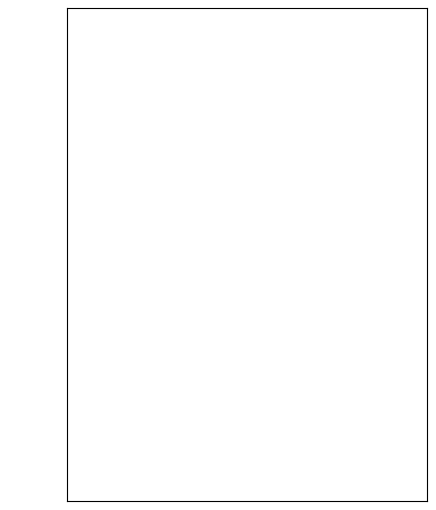

In [ ]:
plt.figure(figsize=(5.5, 6.5))
cm = ClusterMapPlotter(
        data=df_heatmap,
        col_cluster=False,
        row_cluster=True,
        # col_split=df.AB,
        row_split=2,
        z_score=0,
        # col_split_gap=0.5,
        row_split_gap=0.8,
        label='values',
        row_dendrogram=True,
        col_dendrogram=False,
        row_dendrogram_size=15,
        show_rownames=False,
        show_colnames=True,
        tree_kws={'row_cmap': 'Set1'},
        verbose=0,
        legend_gap=5,
        cmap='RdYlBu_r',
        xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})

In [ ]:
import scipy
scipy.cluster.hierarchy.linkage(df_heatmap)

array([[ 0.        ,  1.        ,  0.        ,  2.        ],
       [ 2.        , 10.        ,  0.        ,  3.        ],
       [ 3.        , 11.        ,  0.        ,  4.        ],
       [ 4.        , 12.        ,  0.        ,  5.        ],
       [ 5.        , 13.        ,  0.        ,  6.        ],
       [ 6.        , 14.        ,  0.        ,  7.        ],
       [ 8.        , 15.        ,  0.        ,  8.        ],
       [ 9.        , 16.        ,  0.        ,  9.        ],
       [ 7.        , 17.        ,  1.73031876, 10.        ]])

In [ ]:
np.all(np.isfinite(df_heatmap))

True

# Clustergrammer

In [ ]:
import os, sys
from google.colab import drive

<IPython.core.display.Javascript object>

In [ ]:
!pip install virtualenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 26.2 MB/s eta 0:00:00


In [ ]:
# !source /content/drive/MyDrive/Omkar_Masters_thesis/Actin_analysis/colab_env/bin/activate; pip install clustergrammer2
!source /content/drive/MyDrive/Omkar_Masters_thesis/Actin_analysis/colab_env/bin/activate
sys.path.append("/content/drive/MyDrive/Omkar_Masters_thesis/Actin_analysis/colab_env/lib/python3.10/site-packages")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# enable custom widgets
# https://github.com/googlecolab/colabtools/issues/498
from google.colab import output
output.enable_custom_widget_manager()
# %%capture
from clustergrammer2 import net, CGM2, Network
import numpy as np
import pandas as pd
import pickle
import os

from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(1, true, {maxHeight: 50000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Interface_matrix_with_annotations

In [ ]:
#@title load data
savepath = "./actin_dataset/actin_database_sheets"
with open(os.path.join(savepath,"actin_interface_matrix.pkl"), 'rb') as g:
    actin_interactor_interface_dict = pickle.load(g)

with open(os.path.join(savepath,"actin_interactor_domains.pkl"), 'rb') as g:
    actin_interactor_domains = pickle.load(g)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title unavailable annotations
mod_actin_interactor_interface_dict = {}
for key1, value1 in actin_interactor_interface_dict.items():
  if key1 not in list(actin_interactor_domains.keys()):
    print(key1)
  else:
    mod_actin_interactor_interface_dict[key1] = value1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

('8BJJ_1', ('A_act', 'P68135'), ('B', 'A0A6N3LUE9'))
('8A5A_1', ('V_act', 'P60010'), ('X', 'Q08561'))
('8BO1_1', ('A_act', 'P68135'), ('B', 'A0A6N3LUE9'))
('8BO1_2', ('C_act', 'P68135'), ('D', 'A0A6N3LUE9'))
('8BR1_1', ('A_act', 'P68135'), ('B', 'A0A6N3LUE9'))
('8BR1_2', ('C_act', 'P68135'), ('D', 'A0A6N3LUE9'))
('8A5O_1', ('V_act', 'P60010'), ('X', 'Q08561'))
('4M63_1', ('C_act', 'P10987'), ('A', 'L0I5A1'))
('4M63_1', ('E_act', 'P10987'), ('B', 'L0I5A1'))
('4M63_1', ('C_act', 'P10987'), ('B', 'L0I5A1'))


In [ ]:
#@title interface matrix
heatmap_dict = {}
mod_interface_dict = {}
for key, value in mod_actin_interactor_interface_dict.items():
  if 'act' in key[2][0]:
    mod_interface_dict[key] = value
  #else:
  # mod_interface_dict[key] = value

for key, value in mod_interface_dict.items():
  for residx in range(1, len(value)+1):
    heatmap_dict[(key, residx)] = value[residx - 1]

ser = pd.Series(list(heatmap_dict.values()),index=pd.MultiIndex.from_tuples(heatmap_dict.keys()))
interface_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
interface_df.to_csv(os.path.join(savepath,"actin_interface_matrix_temp.csv"))

dom_lst_len = 0
for key, value in actin_interactor_domains.items():
  dom_lst = value
  if len(dom_lst) > dom_lst_len:
    dom_lst_len = len(dom_lst)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title domain annotations df
for key, value in actin_interactor_domains.items():
  dom_lst = value
  while len(dom_lst) < 4:
    dom_lst.append('undefined')
  actin_interactor_domains[key] = dom_lst

dom_dict = {}
for key, value in actin_interactor_domains.items():
  for domidx in range(1, len(value)+1):
    dom_dict[(key, domidx)] = value[domidx-1]

ser = pd.Series(list(dom_dict.values()),index=pd.MultiIndex.from_tuples(dom_dict.keys()))
dom_df = ser.unstack().fillna(0)

savepath = "./actin_dataset/actin_database_sheets" #param {type: "string"}
dom_df.to_csv(os.path.join(savepath,"actin_interactor_domain_annot_temp.csv"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title interface matrix load
interface_mtrx = "./actin_dataset/actin_database_sheets/actin_interface_matrix_temp.csv"
#markdown - **mtrx** `-` row names of interface matrix
mtrx = pd.read_csv(interface_mtrx, index_col = 0)
#mtrx = mtrx.iloc[0:100]

for id, row in mtrx.iterrows():
  row_lst = list(row)
  for elem in row_lst:
    if elem != 0.0 and elem!= 1.0:
      print(elem)

mtrx = mtrx.replace(0.0, 0.001)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title domain annot matric load
#df_dom = pd.DataFrame('Undefined', index=mtrx.index.tolist(), columns=['Domain'])
domain_annot_mtrx = "./actin_dataset/actin_database_sheets/actin_interactor_domain_annot_temp.csv"
df_dom = pd.read_csv(domain_annot_mtrx, index_col = 0)
#for id, row in df_dom.iterrows():
  #int_unp = id[2][1]
#  df_dom.loc[id, 'Domain'] = actin_interactor_domains[id]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title domain merging
domain_diction = {}
for index, row in df_dom.iterrows():
  domain_lst = [dom for dom in list(row) if dom not in ["undefined"]]
  domain_diction[index] = domain_lst

for k, v in domain_diction.items():
  if v == []:
    print(k, v)
  elif len(list(filter(lambda x: x != 'non_rep_domain', v))) > 1:
    # print(k,v)
    domain_diction[k] = [list(filter(lambda x: x != 'non_rep_domain', v))[0]]
  elif len(list(filter(lambda x: x != 'non_rep_domain', v))) == 1:
    # print(k,v)
    domain_diction[k] = list(filter(lambda x: x != 'non_rep_domain', v))

for k, v in domain_diction.items():
  if len(v) != 1:
    print(k,v)
df_dom1 = df_dom.from_dict(domain_diction, orient='index', dtype=None)
df_dom1.columns = ['1']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
row_d = {}
for index, row in mtrx.iterrows():
  index = eval(index)
  row_d[index[0]+'_'+index[1][0]+'_'+index[2][0]] = list(row)

n_mtrx = pd.DataFrame.from_dict(row_d, orient = 'index')

row_d = {}
for index, row in df_dom1.iterrows():
  index = eval(index)
  row_d[index[0]+'_'+index[1][0]+'_'+index[2][0]] = list(row)

n_df_dom1 = pd.DataFrame.from_dict(row_d, orient = 'index')
n_df_dom1.columns = ['1']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## viz

In [ ]:
# setting some preferred categories is required, but you can write out other
# custom categories as well in the dendrogram menu
net.reset()
meta_cat = pd.DataFrame()
meta_cat.loc['dog', 'color'] = 'red'
#for i in range(1, 350):
#  meta_cat.loc[i, 'color'] = 'red'
meta_cat.loc['cat', 'color'] = 'blue'
net.load_df(n_mtrx, meta_row = n_df_dom1)

net.set_cat_color(0,2, '1: non_rep_domain', '#ffffff')
# net.set_cat_color(0,3, '3: non_rep_domain', '#ffffff')
net.set_cat_color(0,2, '2: undefined', '#ffffff')
net.set_cat_color(0,3, '3: undefined', '#ffffff')
net.set_cat_color(0,4, '4: undefined', '#ffffff')
mtrx_df = net.export_df()
net.load_df(mtrx_df)

#net.normalize(norm_type='zscore', axis='row')
#net.downsample(ds_type='kmeans', axis='row', num_samples=5, random_state=1000)
#net.set_manual_category(col='Label', preferred_cats=meta_cat)
net.cluster(dist_type='euclidean', linkage_type='ward', dendro=True, views=['N_row_clust', 'N_row_ini'], sim_mat=True)
net.widget()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CGM2(network='{"row_nodes": [{"name": "1LCU_1_A_act_B_act", "ini": 438, "clust": 412, "rank": 239, "rankvar": …

In [ ]:
dfmod = net.export_df()
dfmod.to_csv('example.tsv', sep="\t")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from clustergrammer2 import make_clust_fun
# make_clust_fun.make_clust(net, dist_type='euclidean',sim_mat=True)
# make_clust_fun.make_clust(net, dist_type='euclidean', sim_mat='row')
# net.viz['views']
net.widget('sim_row')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CGM2(network='{"row_nodes": [{"name": "1LCU_1_A_act_B_act", "ini": 438, "clust": 415, "rank": 2, "rankvar": 2,…

In [ ]:
# upload a file to the clustergrammer web app and visualize using an Iframe
from clustergrammer2 import Network
from copy import deepcopy


<IPython.core.display.Javascript object>

In [ ]:
small_mat = pd.read_csv('/content/small_mat1.tsv', sep='\t')

<IPython.core.display.Javascript object>

In [ ]:
net = deepcopy(Network())
link = net.Iframe_web_app('example.tsv')
print(link)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

http://maayanlab.cloud/clustergrammer/viz/65c383e8a2b01c00fcaa5e44/example.tsv
